# Capstone NLP Project - American Presidential Speeches

## Data Cleaning/EDA

### Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn. metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.corpus import gutenberg, stopwords 
from nltk.collocations import * 
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud
import string
import re

In [2]:
def preprocessed_speeches(Transcript):
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

    tokenized_speech = tokenizer.tokenize(Transcript)
    
    lemmatizer = WordNetLemmatizer()
    
    filtered_speech=[]
    for w in tokenized_speech:
        if w.lower() not in sw_set:
            filtered_speech.append(w.lower())
    
    
    lemmatized_speech=[]
    for w in filtered_speech:
        lemmatized_speech.append(lemmatizer.lemmatize(w))
        
    return lemmatized_speech
        
#     fdist = FreqDist(lemmatized_speech)
#     plt.figure(figsize=(10,10))
#     fdist.plot(30) 

In [3]:
def plot_lemmatized(speeches):
    # Speeches is a df that contains a column Transcript which contains the speech
    lem_df = pd.DataFrame(columns=['Lemmatized'])
    lem_df['Lemmatized'] = speeches['Transcript'].apply(lambda x: preprocessed_speeches(x))
    
    # This is going to hold all of the lemmatized words across all speeches
    container = []
    for i in range(len(lem_df)):
        # Iterate through each lemmatized row and extend to container, want just 1 singular list
        container.extend(lem_df['Lemmatized'].iloc[i])
    fdist = FreqDist(container)
    plt.figure(figsize=(10,10))
    plt.xlabel('Words')
    plt.ylabel('Word Count')
    fdist.plot(30)

In [4]:
def run_model(model, X_lem, y_lem):
    
    X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=42)
    
    tfidf = TfidfVectorizer(stop_words=sw_set)

    tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
    tfidf_data_test_lem = tfidf.transform(X_test_lem)
    
    non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
    
    percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
    
    model.fit(tfidf_data_train_lem, y_train_lem)


    y_hat_train = model.predict(tfidf_data_train_lem)
    y_hat_test = model.predict(tfidf_data_test_lem)
    
    print(classification_report(y_train_lem, y_hat_train))
    print(classification_report(y_test_lem, y_hat_test))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))

    plot_confusion_matrix(model, tfidf_data_train_lem, y_train_lem, ax=ax0)
    plot_confusion_matrix(model, tfidf_data_test_lem, y_test_lem, ax=ax1)

    ax0.title.set_text('Train Confusion Matrix')
    ax1.title.set_text('Test Confusion Matrix')
    
    return model

In [5]:
def build_clinton(c_df):
    # Separate by High and low approvals, if approvals > 50, its high, otherwise its low
    c_df['high'], c_df['low'] = (c_df.Approving >= 50).astype(int),(~(c_df.Approving >=50)).astype(int)
    # Renaming columns
    c_df.rename(columns={'Start Date': 'Start_Date', 'End Date': 'End_Date'}, inplace=True)

    # Convert Date columns to date_time type
    c_df['Start_Date'] = pd.to_datetime(c_df['Start_Date'])
    c_df['End_Date'] = pd.to_datetime(c_df['End_Date'])

    # Pulling out the month and the year and grouping the average ratings per month
    c_df['month_year'] = pd.to_datetime(c_df['End_Date']).dt.to_period('M')
    clinton_new_ratings = c_df.groupby('month_year').mean()
    clinton_new_ratings.reset_index(inplace=True)
    return clinton_new_ratings

In [6]:
def merge_clinton_df(speeches_ratings):
    speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')
    merged_clinton_df = clinton_df.merge(speeches_ratings, how='inner', on='month_year')
    merged_clinton_df['high'] = merged_clinton_df['high'].astype(int)
    merged_clinton_df['low'] = merged_clinton_df['low'].astype(int)
    merged_clinton_df['Approving'] = merged_clinton_df['Approving'].astype(int)
    merged_clinton_df['Disapproving'] = merged_clinton_df['Disapproving'].astype(int)
    merged_clinton_df['Unsure/NoData'] = merged_clinton_df['Unsure/NoData'].astype(int)
    return merged_clinton_df

In [7]:
def merge_bush_df(speeches_ratings):
    speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')
    merged_bush_df = bush_df.merge(speeches_ratings, how='inner', on='month_year')
    merged_bush_df['high'] = merged_bush_df['high'].astype(int)
    merged_bush_df['low'] = merged_bush_df['low'].astype(int)
    merged_bush_df['Approving'] = merged_bush_df['Approving'].astype(int)
    merged_bush_df['Disapproving'] = merged_bush_df['Disapproving'].astype(int)
    merged_bush_df['Unsure/NoData'] = merged_bush_df['Unsure/NoData'].astype(int)
    return merged_bush_df

In [8]:
def merge_obama_df(speeches_ratings):
    speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')
    merged_obama_df = obama_df.merge(speeches_ratings, how='inner', on='month_year')
    merged_obama_df['high'] = merged_obama_df['high'].astype(int)
    merged_obama_df['low'] = merged_obama_df['low'].astype(int)
    merged_obama_df['Approving'] = merged_obama_df['Approving'].astype(int)
    merged_obama_df['Disapproving'] = merged_obama_df['Disapproving'].astype(int)
    merged_obama_df['Unsure/NoData'] = merged_obama_df['Unsure/NoData'].astype(int)
    return merged_obama_df

In [9]:
def merge_trump_df(speeches_ratings):
    speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')
    merged_trump_df = trump_df.merge(speeches_ratings, how='inner', on='month_year')
    merged_trump_df['high'] = merged_trump_df['high'].astype(int)
    merged_trump_df['low'] = merged_trump_df['low'].astype(int)
    merged_trump_df['Approving'] = merged_trump_df['Approving'].astype(int)
    merged_trump_df['Disapproving'] = merged_trump_df['Disapproving'].astype(int)
    merged_trump_df['Unsure/NoData'] = merged_trump_df['Unsure/NoData'].astype(int)
    return merged_trump_df

In [10]:
def return_lemmatized(speeches):
    # Speeches is a df that contains a column Transcript which contains the speech
    lem_df = pd.DataFrame(columns=['Lemmatized'])
    lem_df['Lemmatized'] = speeches['Transcript'].apply(lambda x: preprocessed_speeches(x))
    
    # This is going to hold all of the lemmatized words across all speeches
    container = []
    for i in range(len(lem_df)):
        # Iterate through each lemmatized row and extend to container, want just 1 singular list
        container.extend(lem_df['Lemmatized'].iloc[i])
    fdist = FreqDist(container)
    return fdist

### Presidential Speeches EDA

In [11]:
df = pd.read_csv('presidential_speeches.csv')
df.head()

Date          President         Party  \
0  1789-04-30  George Washington  Unaffiliated   
1  1789-10-03  George Washington  Unaffiliated   
2  1790-01-08  George Washington  Unaffiliated   
3  1790-12-08  George Washington  Unaffiliated   
4  1790-12-29  George Washington  Unaffiliated   

                                        Speech Title  \
0                            First Inaugural Address   
1                          Thanksgiving Proclamation   
2                   First Annual Message to Congress   
3                  Second Annual Message to Congress   
4  Talk to the Chiefs and Counselors of the Senec...   

                                             Summary  \
0  Washington calls on Congress to avoid local an...   
1  At the request of Congress, Washington establi...   
2  In a wide ranging speech, President Washington...   
3  Washington focuses on commerce in his second a...   
4  The President reassures the Seneca Nation that...   

                                          Transcript  \
0  Fellow Citizens of the Senate and the House of...   
1  Whereas it is the duty of all Nations to ackno...   
2  Fellow Citizens of the Senate and House of Rep...   
3  Fellow citizens of the Senate and House of Rep...   
4  I the President of the United States, by my ow...   

                                                 URL  
0  https://millercenter.org/the-presidency/presid...  
1  https://millercenter.org/the-presidency/presid...  
2  https://millercenter.org/the-presidency/presid...  
3  https://millercenter.org/the-presidency/presid...  
4  https://millercenter.org/the-presidency/presid...

In [12]:
df.describe()

Date          President       Party                Speech Title  \
count          992                992         992                         992   
unique         970                 44           6                         716   
top     1920-07-22  Lyndon B. Johnson  Democratic  State of the Union Address   
freq             5                 71         478                          42   

                                                  Summary  \
count                                                 687   
unique                                                687   
top     President Obama speaks at "Together We Thrive:...   
freq                                                    1   

                                               Transcript  \
count                                                 991   
unique                                                987   
top     To the Senate and House of Representatives: In...   
freq                                                    2   

                                                      URL  
count                                                 992  
unique                                                992  
top     https://millercenter.org/the-presidency/presid...  
freq                                                    1

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          992 non-null    object
 1   President     992 non-null    object
 2   Party         992 non-null    object
 3   Speech Title  992 non-null    object
 4   Summary       687 non-null    object
 5   Transcript    991 non-null    object
 6   URL           992 non-null    object
dtypes: object(7)
memory usage: 54.4+ KB


In [14]:
df.shape

(992, 7)

In [15]:
df.President.unique()

array(['George Washington', 'John Adams', 'Thomas Jefferson',
       'James Madison', 'James Monroe', 'John Quincy Adams',
       'Andrew Jackson', 'Martin Van Buren', 'William Harrison',
       'John Tyler', 'James K. Polk', 'Zachary Taylor',
       'Millard Fillmore', 'Abraham Lincoln', 'Franklin Pierce',
       'James Buchanan', 'Andrew Johnson', 'Ulysses S. Grant',
       'Rutherford B. Hayes', 'James A. Garfield', 'Chester A. Arthur',
       'Grover Cleveland', 'Benjamin Harrison', 'William McKinley',
       'Theodore Roosevelt', 'William Taft', 'Woodrow Wilson',
       'Warren G. Harding', 'Calvin Coolidge', 'Herbert Hoover',
       'Franklin D. Roosevelt', 'Harry S. Truman', 'Richard M. Nixon',
       'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson',
       'Ronald Reagan', 'Gerald Ford', 'Jimmy Carter',
       'George H. W. Bush', 'Bill Clinton', 'George W. Bush',
       'Barack Obama', 'Donald Trump'], dtype=object)

In [16]:
df.Date.unique()

array(['1789-04-30', '1789-10-03', '1790-01-08', '1790-12-08',
       '1790-12-29', '1791-10-25', '1792-04-05', '1792-11-06',
       '1792-12-12', '1793-03-04', '1793-04-22', '1793-12-03',
       '1794-08-07', '1794-09-25', '1794-11-19', '1795-07-10',
       '1795-12-08', '1796-03-30', '1796-08-29', '1796-09-19',
       '1796-12-07', '1797-03-04', '1797-05-16', '1797-11-22',
       '1798-03-23', '1798-12-08', '1799-12-03', '1799-12-19',
       '1800-05-21', '1800-11-22', '1801-03-04', '1801-07-12',
       '1801-12-08', '1802-01-01', '1802-11-03', '1802-12-15',
       '1803-01-18', '1803-06-20', '1803-10-17', '1803-12-17',
       '1804-11-08', '1805-03-04', '1805-12-03', '1805-12-06',
       '1806-01-10', '1806-11-27', '1806-12-02', '1806-12-30',
       '1807-01-22', '1807-02-10', '1807-07-02', '1807-10-27',
       '1808-11-08', '1809-03-04', '1809-04-03', '1809-05-23',
       '1809-11-29', '1810-10-27', '1810-12-05', '1811-02-21',
       '1811-11-05', '1812-06-01', '1812-06-19', '1812-

In [17]:
df.Party.unique()

array(['Unaffiliated', 'Federalist', 'Democratic-Republican',
       'Democratic', 'Whig', 'Republican'], dtype=object)

In [18]:
df['Speech Title'].unique()

array(['First Inaugural Address', 'Thanksgiving Proclamation',
       'First Annual Message to Congress',
       'Second Annual Message to Congress',
       'Talk to the Chiefs and Counselors of the Seneca Nation',
       'Third Annual Message to Congress',
       'Veto Message on Congressional Redistricting',
       'Fourth Annual Message to Congress',
       'Proclamation Against Crimes Against the Cherokee Nations',
       'Second Inaugural Address', 'Proclamation of Neutrality',
       'Fifth Annual Message to Congress',
       'Proclamation against Opposition to Execution of Laws and Excise Duties in Western Pennsylvania',
       'Proclamation of Militia Service',
       'Sixth Annual Message to Congress',
       'Proclamation of Pardons in Western Pennsylvania',
       'Seventh Annual Message to Congress',
       'Message to the House of Representatives, Declining to Submit Diplomatic Instructions and Corresponde',
       'Talk to the Cherokee Nation', 'Farewell Address',
       

In [19]:
df['Party'].value_counts()

Democratic               478
Republican               389
Democratic-Republican     65
Unaffiliated              39
Whig                      12
Federalist                 9
Name: Party, dtype: int64

In [20]:
df['President'].value_counts()

Lyndon B. Johnson        71
Ronald Reagan            59
Barack Obama             50
Franklin D. Roosevelt    49
John F. Kennedy          44
George W. Bush           39
Bill Clinton             39
Woodrow Wilson           33
Ulysses S. Grant         32
Andrew Johnson           31
Herbert Hoover           30
Grover Cleveland         30
Andrew Jackson           26
James K. Polk            25
Thomas Jefferson         24
George H. W. Bush        23
Richard M. Nixon         23
Benjamin Harrison        23
Theodore Roosevelt       22
James Madison            22
Jimmy Carter             22
George Washington        21
Harry S. Truman          19
Donald Trump             19
Warren G. Harding        18
John Tyler               18
Rutherford B. Hayes      16
Franklin Pierce          15
Abraham Lincoln          15
James Buchanan           14
Gerald Ford              14
William McKinley         14
Calvin Coolidge          12
William Taft             12
Chester A. Arthur        11
Martin Van Buren    

In [21]:
df.isna().sum()

Date              0
President         0
Party             0
Speech Title      0
Summary         305
Transcript        1
URL               0
dtype: int64

In [22]:
df[df['Transcript'].isnull()]

Date         President                  Party  \
52  1808-11-08  Thomas Jefferson  Democratic-Republican   

             Speech Title                                            Summary  \
52  Eighth Annual Message  Jefferson defends the embargo measures at leng...   

   Transcript                                                URL  
52        NaN  https://millercenter.org/the-presidency/presid...

In [23]:
df.Summary[0]

'Washington calls on Congress to avoid local and party partisanship and encourages the adoption of a Bill of Rights, without specifically calling them by name. The first President demonstrates his reluctance to accept the post, rejects any salary for the execution of his duties, and devotes a considerable part of the speech to his religious beliefs.'

In [24]:
df = df.drop(['Summary', 'URL'],axis=1)
df.head()

Date          President         Party  \
0  1789-04-30  George Washington  Unaffiliated   
1  1789-10-03  George Washington  Unaffiliated   
2  1790-01-08  George Washington  Unaffiliated   
3  1790-12-08  George Washington  Unaffiliated   
4  1790-12-29  George Washington  Unaffiliated   

                                        Speech Title  \
0                            First Inaugural Address   
1                          Thanksgiving Proclamation   
2                   First Annual Message to Congress   
3                  Second Annual Message to Congress   
4  Talk to the Chiefs and Counselors of the Senec...   

                                          Transcript  
0  Fellow Citizens of the Senate and the House of...  
1  Whereas it is the duty of all Nations to ackno...  
2  Fellow Citizens of the Senate and House of Rep...  
3  Fellow citizens of the Senate and House of Rep...  
4  I the President of the United States, by my ow...

In [25]:
df=df[(df['Date'] > '1993-01-19') & (df['Date'] < '2019-12-31')]
df.head()

Date     President       Party  \
845  1993-01-20  Bill Clinton  Democratic   
846  1993-01-29  Bill Clinton  Democratic   
847  1993-02-05  Bill Clinton  Democratic   
848  1993-02-17  Bill Clinton  Democratic   
849  1993-04-30  Bill Clinton  Democratic   

                                          Speech Title  \
845                                    First Inaugural   
846         Press Conference on "Gays in the Military"   
847  Remarks at the Signing of the Family Medical L...   
848         Address Before a Joint Session of Congress   
849                           National Service Address   

                                            Transcript  
845  My fellow citizens, today we celebrate the mys...  
846  The President. Good afternoon, ladies and gent...  
847  Thank you very much, thank you. Mrs. Yandle, I...  
848  Mr. President, Mr. Speaker, Members of the Hou...  
849  It is wonderful to be back in New Orleans and ...

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 845 to 991
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          147 non-null    object
 1   President     147 non-null    object
 2   Party         147 non-null    object
 3   Speech Title  147 non-null    object
 4   Transcript    147 non-null    object
dtypes: object(5)
memory usage: 6.9+ KB


In [27]:
new_df = df.reset_index(drop=True)
new_df.head()

Date     President       Party  \
0  1993-01-20  Bill Clinton  Democratic   
1  1993-01-29  Bill Clinton  Democratic   
2  1993-02-05  Bill Clinton  Democratic   
3  1993-02-17  Bill Clinton  Democratic   
4  1993-04-30  Bill Clinton  Democratic   

                                        Speech Title  \
0                                    First Inaugural   
1         Press Conference on "Gays in the Military"   
2  Remarks at the Signing of the Family Medical L...   
3         Address Before a Joint Session of Congress   
4                           National Service Address   

                                          Transcript  
0  My fellow citizens, today we celebrate the mys...  
1  The President. Good afternoon, ladies and gent...  
2  Thank you very much, thank you. Mrs. Yandle, I...  
3  Mr. President, Mr. Speaker, Members of the Hou...  
4  It is wonderful to be back in New Orleans and ...

In [28]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.head()

Date     President       Party  \
0 1993-01-20  Bill Clinton  Democratic   
1 1993-01-29  Bill Clinton  Democratic   
2 1993-02-05  Bill Clinton  Democratic   
3 1993-02-17  Bill Clinton  Democratic   
4 1993-04-30  Bill Clinton  Democratic   

                                        Speech Title  \
0                                    First Inaugural   
1         Press Conference on "Gays in the Military"   
2  Remarks at the Signing of the Family Medical L...   
3         Address Before a Joint Session of Congress   
4                           National Service Address   

                                          Transcript  
0  My fellow citizens, today we celebrate the mys...  
1  The President. Good afternoon, ladies and gent...  
2  Thank you very much, thank you. Mrs. Yandle, I...  
3  Mr. President, Mr. Speaker, Members of the Hou...  
4  It is wonderful to be back in New Orleans and ...

# Stop Words Removal

In [29]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '.',
            'said', 'and', 'but', 'the', '-', '–', '—', 'let', ',', 'get', '1', '1', 'like', 'lot']
sw_set = set(sw_list)

In [30]:
print(sw_set)

{"weren't", '%', 'before', 'so', 'haven', 'me', 'further', 'again', 've', 'doing', 'like', "you'd", '`', 'himself', 'own', 'those', 'below', 'will', ':', 'their', ')', 'themselves', 'out', 'at', '‘', "you've", 'shouldn', 'with', 'up', 'until', 'if', 'how', 'yourself', 'that', 'needn', 'get', '$', 'very', 'while', 'weren', 'do', "shan't", '(', "needn't", 'm', 'the', 'when', '—', "don't", 'they', '``', 's', '<', "''", 't', 'itself', 'who', 'be', 'to', 'does', 'did', 'is', 'didn', 'you', 'over', 'them', 'having', 'down', '–', '!', "won't", 'have', 'between', "mustn't", 'few', 'doesn', '=', 'hers', '-', 'under', 'lot', 'our', 'and', 'any', '~', ',', 'a', "isn't", 'only', 'of', 'than', '“', 'myself', 'were', 'nor', 'other', '+', 'where', 'this', 'his', 'can', 'which', 'o', 'all', 'as', 'its', 'theirs', '/', 'too', '_', "haven't", 'wouldn', "that'll", '"', "couldn't", '?', 'there', 'from', 'whom', 'd', 'my', 'such', 'aren', "didn't", '...', 'mustn', 'because', 'not', '#', 'an', 'why', "it's"

# President Clinton Speeches and Job Approval Ratings EDA

In [31]:
clinton_speeches=new_df[(new_df['President'] == 'Bill Clinton')]
clinton_speeches.head()

Date     President       Party  \
0 1993-01-20  Bill Clinton  Democratic   
1 1993-01-29  Bill Clinton  Democratic   
2 1993-02-05  Bill Clinton  Democratic   
3 1993-02-17  Bill Clinton  Democratic   
4 1993-04-30  Bill Clinton  Democratic   

                                        Speech Title  \
0                                    First Inaugural   
1         Press Conference on "Gays in the Military"   
2  Remarks at the Signing of the Family Medical L...   
3         Address Before a Joint Session of Congress   
4                           National Service Address   

                                          Transcript  
0  My fellow citizens, today we celebrate the mys...  
1  The President. Good afternoon, ladies and gent...  
2  Thank you very much, thank you. Mrs. Yandle, I...  
3  Mr. President, Mr. Speaker, Members of the Hou...  
4  It is wonderful to be back in New Orleans and ...

In [32]:
clinton_ratings = pd.read_csv('American Presidency Project - Approval Ratings for POTUS - William J. Clinton.csv')
clinton_ratings

Start Date    End Date  Approving  Disapproving  Unsure/NoData
0    01/10/2001  01/14/2001         66            29              5
1    01/05/2001  01/07/2001         65            31              4
2    12/15/2000  12/17/2000         66            32              2
3    12/02/2000  12/04/2000         60            35              5
4    11/13/2000  11/15/2000         63            33              4
..          ...         ...        ...           ...            ...
211  03/12/1993  03/14/1993         53            34             13
212  02/26/1993  02/28/1993         59            29             12
213  02/12/1993  02/14/1993         51            34             15
214  01/29/1993  01/31/1993         54            30             16
215  01/24/1993  01/26/1993         58            20             22

[216 rows x 5 columns]

In [33]:
clinton_ratings.nunique()

Start Date       216
End Date         216
Approving         33
Disapproving      29
Unsure/NoData     16
dtype: int64

In [34]:
clinton_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Start Date     216 non-null    object
 1   End Date       216 non-null    object
 2   Approving      216 non-null    int64 
 3   Disapproving   216 non-null    int64 
 4   Unsure/NoData  216 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 8.6+ KB


In [35]:
clinton_ratings.describe()

Approving  Disapproving  Unsure/NoData
count  216.000000    216.000000     216.000000
mean    55.490741     37.865741       6.643519
std      7.620652      6.251737       2.975521
min     37.000000     20.000000       2.000000
25%     50.000000     34.000000       4.000000
50%     57.000000     37.000000       7.000000
75%     60.250000     42.000000       9.000000
max     73.000000     54.000000      22.000000

In [36]:
clinton_df = build_clinton(clinton_ratings)
clinton_df

month_year  Approving  Disapproving  Unsure/NoData  high  low
0     1993-01       56.0          25.0           19.0   1.0  0.0
1     1993-02       55.0          31.5           13.5   1.0  0.0
2     1993-03       52.5          35.5           12.0   1.0  0.0
3     1993-04       55.0          37.0            8.0   1.0  0.0
4     1993-05       44.5          45.0           10.5   0.0  1.0
..        ...        ...           ...            ...   ...  ...
92    2000-09       61.0          34.5            4.5   1.0  0.0
93    2000-10       57.5          37.5            5.0   1.0  0.0
94    2000-11       63.0          33.0            4.0   1.0  0.0
95    2000-12       63.0          33.5            3.5   1.0  0.0
96    2001-01       65.5          30.0            4.5   1.0  0.0

[97 rows x 6 columns]

In [37]:
new_clinton_df = merge_clinton_df(clinton_speeches)
new_clinton_df

<ipython-input-6-04212598cd86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')


month_year  Approving  Disapproving  Unsure/NoData  high  low       Date  \
0     1993-01         56            25             19     1    0 1993-01-20   
1     1993-01         56            25             19     1    0 1993-01-29   
2     1993-02         55            31             13     1    0 1993-02-05   
3     1993-02         55            31             13     1    0 1993-02-17   
4     1993-04         55            37              8     1    0 1993-04-30   
5     1993-05         44            45             10     0    1 1993-05-05   
6     1993-06         40            48             10     0    1 1993-06-06   
7     1993-09         49            40             10     0    0 1993-09-13   
8     1993-09         49            40             10     0    0 1993-09-22   
9     1993-10         48            43              8     0    0 1993-10-07   
10    1993-11         48            43              7     0    0 1993-11-13   
11    1993-12         53            39              8     1    0 1993-12-08   
12    1994-01         55            37              7     1    0 1994-01-25   
13    1994-06         46            46              7     0    1 1994-06-06   
14    1994-07         42            48              9     0    1 1994-07-12   
15    1995-01         47            45              8     0    1 1995-01-24   
16    1995-04         48            43              9     0    0 1995-04-23   
17    1995-07         47            43             10     0    1 1995-07-19   
18    1995-10         47            41             11     0    1 1995-10-16   
19    1995-11         52            39              8     1    0 1995-11-27   
20    1995-11         52            39              8     1    0 1995-11-30   
21    1996-01         46            46              7     0    0 1996-01-23   
22    1996-06         55            39              5     1    0 1996-06-25   
23    1996-08         54            38              8     1    0 1996-08-29   
24    1996-10         56            35              8     1    0 1996-10-06   
25    1996-11         58            35              7     1    0 1996-11-03   
26    1997-01         60            33              7     1    0 1997-01-20   
27    1997-02         58            32              9     1    0 1997-02-04   
28    1997-04         54            37              9     1    0 1997-04-22   
29    1998-01         59            33              7     1    0 1998-01-26   
30    1998-01         59            33              7     1    0 1998-01-27   
31    1998-03         64            29              6     1    0 1998-03-23   
32    1998-03         64            29              6     1    0 1998-03-25   
33    1998-08         63            32              4     1    0 1998-08-17   
34    1999-01         68            29              2     1    0 1999-01-19   
35    1999-03         64            32              3     1    0 1999-03-24   
36    1999-06         59            37              3     1    0 1999-06-10   
37    2000-01         62            34              3     1    0 2000-01-27   
38    2001-01         65            30              4     1    0 2001-01-18   

       President       Party  \
0   Bill Clinton  Democratic   
1   Bill Clinton  Democratic   
2   Bill Clinton  Democratic   
3   Bill Clinton  Democratic   
4   Bill Clinton  Democratic   
5   Bill Clinton  Democratic   
6   Bill Clinton  Democratic   
7   Bill Clinton  Democratic   
8   Bill Clinton  Democratic   
9   Bill Clinton  Democratic   
10  Bill Clinton  Democratic   
11  Bill Clinton  Democratic   
12  Bill Clinton  Democratic   
13  Bill Clinton  Democratic   
14  Bill Clinton  Democratic   
15  Bill Clinton  Democratic   
16  Bill Clinton  Democratic   
17  Bill Clinton  Democratic   
18  Bill Clinton  Democratic   
19  Bill Clinton  Democratic   
20  Bill Clinton  Democratic   
21  Bill Clinton  Democratic   
22  Bill Clinton  Democratic   
23  Bill Clinton  Democratic   
24  Bill Clinton  Democratic   
25  Bill C

President Clinton's job approval ratings while in office:

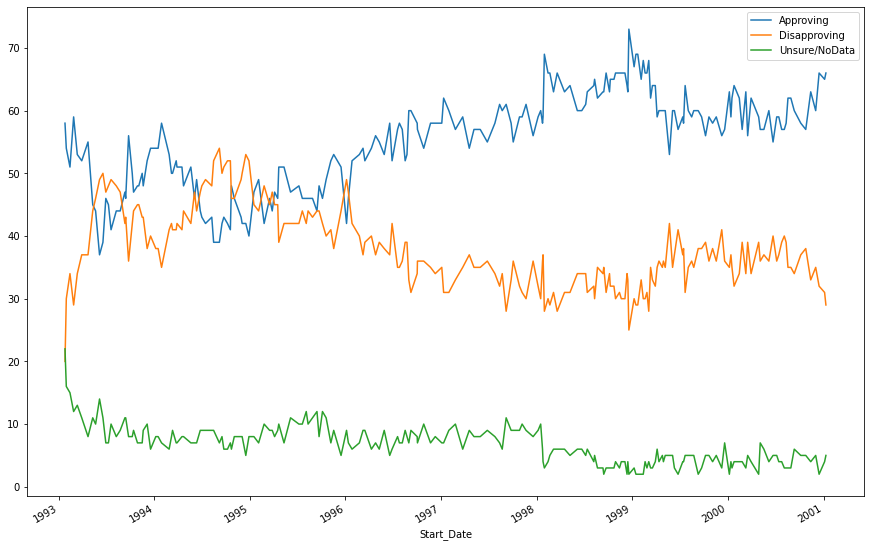

In [38]:
clinton_ratings.plot(x="Start_Date", y=["Approving", "Disapproving", "Unsure/NoData"], figsize=(15, 10))
plt.show()

In [39]:
clinton_transcript  = clinton_speeches[['Transcript']]

In [40]:
clinton_transcript['Lemmatized'] = clinton_transcript['Transcript'].apply(lambda x: preprocessed_speeches(x))

<ipython-input-40-45e8fd5fb2e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_transcript['Lemmatized'] = clinton_transcript['Transcript'].apply(lambda x: preprocessed_speeches(x))


In [41]:
clinton_transcript.head()

Transcript  \
0  My fellow citizens, today we celebrate the mys...   
1  The President. Good afternoon, ladies and gent...   
2  Thank you very much, thank you. Mrs. Yandle, I...   
3  Mr. President, Mr. Speaker, Members of the Hou...   
4  It is wonderful to be back in New Orleans and ...   

                                          Lemmatized  
0  [fellow, citizen, today, celebrate, mystery, a...  
1  [president, good, afternoon, lady, gentleman, ...  
2  [thank, much, thank, mr, yandle, never, better...  
3  [mr, president, mr, speaker, member, house, se...  
4  [wonderful, back, new, orleans, louisiana, fir...

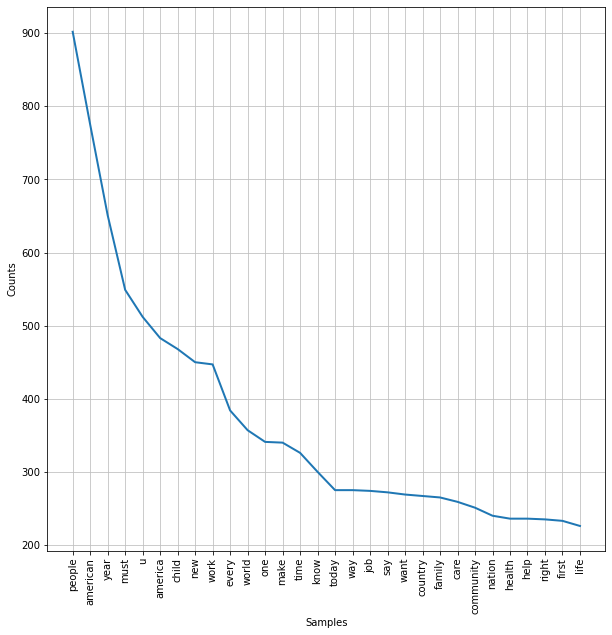

In [42]:
plot_lemmatized(clinton_speeches)

# President Bush Speeches and Job Approval Ratings EDA

In [43]:
bush_speeches=new_df[(new_df['President'] == 'George W. Bush')]
bush_speeches.head()

Date       President       Party  \
39 2001-01-20  George W. Bush  Republican   
40 2001-01-29  George W. Bush  Republican   
41 2001-05-11  George W. Bush  Republican   
42 2001-06-07  George W. Bush  Republican   
43 2001-08-09  George W. Bush  Republican   

                                         Speech Title  \
39                            First Inaugural Address   
40   Remarks on Faith-Based and Community Initiatives   
41  Proposal for Global Fund to Fight HIV/AIDS, Ma...   
42  Remarks on Signing the Economic Growth and Tax...   
43        Address to the Nation on Stem Cell Research   

                                           Transcript  
39  President Clinton, distinguished guests and my...  
40  Good morning. Thank you all for coming. I take...  
41  It is my honor to welcome our friend, the Pres...  
42  Thank you. Sit down. Behave yourself. You're a...  
43  Good evening. I appreciate you giving me a few...

In [44]:
bush_ratings = pd.read_csv('American Presidency Project - Approval Ratings for POTUS - George W. Bush.csv')
bush_ratings

Start Date    End Date  Approving  Disapproving  Unsure/NoData
0    01/09/2009  01/11/2009         34            61              5
1    12/12/2008  12/14/2008         29            67              4
2    12/04/2008  12/07/2008         32            61              7
3    11/13/2008  11/16/2008         29            66              5
4    11/07/2008  11/09/2008         28            68              4
..          ...         ...        ...           ...            ...
277    3/9/2001   3/11/2001         58            29             13
278    3/5/2001    3/7/2001         63            22             15
279   2/19/2001   2/21/2001         62            21             17
280    2/9/2001   2/11/2001         57            25             18
281    2/1/2001    2/4/2001         57            25             18

[282 rows x 5 columns]

In [45]:
bush_ratings.nunique()

Start Date       282
End Date         282
Approving         62
Disapproving      64
Unsure/NoData     17
dtype: int64

In [46]:
bush_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Start Date     282 non-null    object
 1   End Date       282 non-null    object
 2   Approving      282 non-null    int64 
 3   Disapproving   282 non-null    int64 
 4   Unsure/NoData  282 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 11.1+ KB


In [47]:
bush_ratings.describe()

Approving  Disapproving  Unsure/NoData
count  282.000000    282.000000     282.000000
mean    51.347518     43.843972       4.808511
std     15.873381     16.412513       2.628654
min     25.000000      6.000000       1.000000
25%     37.000000     32.000000       3.000000
50%     50.500000     46.000000       4.000000
75%     62.000000     59.000000       5.000000
max     90.000000     71.000000      18.000000

In [48]:
bush_df = build_clinton(bush_ratings)
bush_df

month_year  Approving  Disapproving  Unsure/NoData  high  low
0     2001-02  58.666667     23.666667      17.666667   1.0  0.0
1     2001-03  58.000000     26.666667      15.333333   1.0  0.0
2     2001-04  60.500000     29.500000      10.000000   1.0  0.0
3     2001-05  55.000000     33.333333      11.666667   1.0  0.0
4     2001-06  55.000000     34.000000      11.000000   1.0  0.0
..        ...        ...           ...            ...   ...  ...
91    2008-09  30.333333     66.000000       3.666667   0.0  1.0
92    2008-10  27.000000     69.000000       4.000000   0.0  1.0
93    2008-11  27.333333     68.000000       4.666667   0.0  1.0
94    2008-12  30.500000     64.000000       5.500000   0.0  1.0
95    2009-01  34.000000     61.000000       5.000000   0.0  1.0

[96 rows x 6 columns]

In [49]:
new_bush_df = merge_bush_df(bush_speeches)
new_bush_df

<ipython-input-7-6f32151797c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')


month_year  Approving  Disapproving  Unsure/NoData  high  low       Date  \
0     2001-05         55            33             11     1    0 2001-05-11   
1     2001-06         55            34             11     1    0 2001-06-07   
2     2001-08         56            35              9     1    0 2001-08-09   
3     2001-09         75            18              6     1    0 2001-09-11   
4     2001-09         75            18              6     1    0 2001-09-21   
5     2002-01         83            12              3     1    0 2002-01-08   
6     2002-01         83            12              3     1    0 2002-01-29   
7     2002-06         73            20              6     1    0 2002-06-01   
8     2002-06         73            20              6     1    0 2002-06-06   
9     2002-06         73            20              6     1    0 2002-06-19   
10    2002-09         67            28              4     1    0 2002-09-12   
11    2003-01         60            35              5     1    0 2003-01-28   
12    2003-03         65            30              4     1    0 2003-03-17   
13    2003-03         65            30              4     1    0 2003-03-19   
14    2003-11         51            45              3     1    0 2003-11-06   
15    2003-12         58            39              2     1    0 2003-12-08   
16    2004-01         57            39              3     1    0 2004-01-07   
17    2004-01         57            39              3     1    0 2004-01-20   
18    2004-07         48            48              4     0    1 2004-07-17   
19    2004-09         52            45              2     1    0 2004-09-03   
20    2005-01         51            44              3     1    0 2005-01-20   
21    2005-02         52            44              3     0    0 2005-02-02   
22    2005-08         43            53              3     0    1 2005-08-31   
23    2005-09         43            52              3     0    1 2005-09-15   
24    2005-12         42            54              3     0    1 2005-12-18   
25    2006-01         43            53              3     0    1 2006-01-31   
26    2006-07         39            56              4     0    1 2006-07-19   
27    2007-01         35            61              3     0    1 2007-01-10   
28    2007-01         35            61              3     0    1 2007-01-23   
29    2007-04         37            59              4     0    1 2007-04-09   
30    2008-01         33            62              5     0    1 2008-01-28   
31    2008-03         32            64              4     0    1 2008-03-19   
32    2008-10         27            69              4     0    1 2008-10-03   
33    2008-11         27            68              4     0    1 2008-11-13   
34    2008-12         30            64              5     0    1 2008-12-19   
35    2009-01         34            61              5     0    1 2009-01-12   
36    2009-01         34            61              5     0    1 2009-01-15   

         President       Party  \
0   George W. Bush  Republican   
1   George W. Bush  Republican   
2   George W. Bush  Republican   
3   George W. Bush  Republican   
4   George W. Bush  Republican   
5   George W. Bush  Republican   
6   George W. Bush  Republican   
7   George W. Bush  Republican   
8   George W. Bush  Republican   
9   George W. Bush  Republican   
10  George W. Bush  Republican   
11  George W. Bush  Republican   
12  George W. Bush  Republican   
13  George W. Bush  Republican   
14  George W. Bush  Republican   
15  George W. Bush  Republican   
16  George W. Bush  Republican   
17  George W. Bush  Republican   
18  George W. Bush  Republican   
19  George W. Bush  Republican   
20  George W. Bush  Republican   
21  George W. Bush  Republican   
22  George W. Bush  Republican   
23  George W. Bush  Republican   
24  George W. Bush  Republican   
25  George W. Bush  Republican   
26  George W. Bush  Republican   
27  George W. Bush  Republican   
28  George W. 

In [50]:
new_bush_df.shape

(37, 11)

President Bush's job approval ratings while in office:

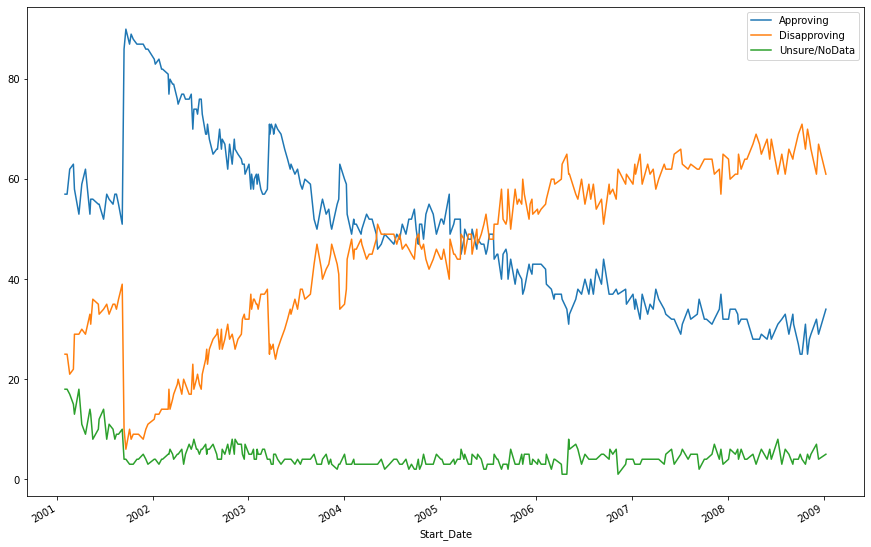

In [51]:
bush_ratings.plot(x="Start_Date", y=["Approving", "Disapproving", "Unsure/NoData"], figsize=(15, 10))
plt.show()

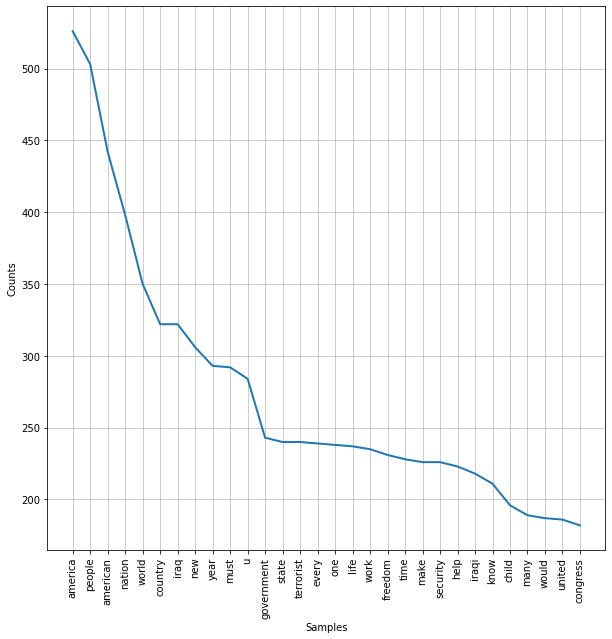

In [52]:
plot_lemmatized(bush_speeches)

# President Obama Speeches and Job Approval Ratings EDA

In [53]:
obama_speeches=new_df[(new_df['President'] == 'Barack Obama')]
obama_speeches.head()

Date     President       Party  \
73 2008-08-28  Barack Obama  Democratic   
75 2008-11-04  Barack Obama  Democratic   
80 2009-01-20  Barack Obama  Democratic   
81 2009-01-29  Barack Obama  Democratic   
82 2009-02-07  Barack Obama  Democratic   

                                         Speech Title  \
73  Acceptance Speech at the Democratic National C...   
75                          Remarks on Election Night   
80                                  Inaugural Address   
81  Remarks on the Lilly Ledbetter Fair Pay Restor...   
82  Remarks on the American Recovery and Reinvestm...   

                                           Transcript  
73  To Chairman Dean and my great friend Dick Durb...  
75  If there is anyone out there who still doubts ...  
80  I stand here today humbled by the task before ...  
81  It is fitting that with the very first bill I ...  
82  Thank you, everybody. Please have a seat. You ...

In [54]:
obama_speeches

Date     President       Party  \
73  2008-08-28  Barack Obama  Democratic   
75  2008-11-04  Barack Obama  Democratic   
80  2009-01-20  Barack Obama  Democratic   
81  2009-01-29  Barack Obama  Democratic   
82  2009-02-07  Barack Obama  Democratic   
83  2009-02-24  Barack Obama  Democratic   
84  2009-05-26  Barack Obama  Democratic   
85  2009-06-04  Barack Obama  Democratic   
86  2009-09-09  Barack Obama  Democratic   
87  2009-12-01  Barack Obama  Democratic   
88  2009-12-10  Barack Obama  Democratic   
89  2010-01-27  Barack Obama  Democratic   
90  2010-02-09  Barack Obama  Democratic   
91  2010-03-15  Barack Obama  Democratic   
92  2010-04-15  Barack Obama  Democratic   
93  2010-04-28  Barack Obama  Democratic   
94  2010-06-15  Barack Obama  Democratic   
95  2010-08-31  Barack Obama  Democratic   
96  2010-09-23  Barack Obama  Democratic   
97  2010-11-03  Barack Obama  Democratic   
98  2011-01-12  Barack Obama  Democratic   
99  2011-01-25  Barack Obama  Democratic   
100 2011-05-01  Barack Obama  Democratic   
101 2011-05-19  Barack Obama  Democratic   
102 2011-05-25  Barack Obama  Democratic   
103 2011-06-22  Barack Obama  Democratic   
104 2011-09-08  Barack Obama  Democratic   
105 2011-10-21  Barack Obama  Democratic   
106 2012-01-24  Barack Obama  Democratic   
107 2012-09-06  Barack Obama  Democratic   
108 2012-11-06  Barack Obama  Democratic   
109 2012-12-16  Barack Obama  Democratic   
110 2013-01-21  Barack Obama  Democratic   
111 2013-01-29  Barack Obama  Democratic   
112 2013-02-13  Barack Obama  Democratic   
113 2013-03-01  Barack Obama  Democratic   
114 2013-03-21  Barack Obama  Democratic   
115 2013-04-08  Barack Obama  Democratic   
116 2013-07-19  Barack Obama  Democratic   
117 2013-07-24  Barack Obama  Democratic   
118 2013-09-10  Barack Obama  Democratic   
119 2013-12-04  Barack Obama  Democratic   
120 2014-01-28  Barack Obama  Democratic   
121 2014-11-20  Barack Obama  Democratic   
122 2015-01-20  Barack Obama  Democratic   
123 2015-03-07  Barack Obama  Democratic   
124 2015-06-26  Barack Obama  Democratic   
125 2016-01-12  Barack Obama  Democratic   
126 2016-03-22  Barack Obama  Democratic   
127 2016-05-15  Barack Obama  Democratic   

                                          Speech Title  \
73   Acceptance Speech at the Democratic National C...   
75                           Remarks on Election Night   
80                                   Inaugural Address   
81   Remarks on the Lilly Ledbetter Fair Pay Restor...   
82   Remarks on the American Recovery and Reinvestm...   
83          Address Before a Joint Session of Congress   
84   Remarks on Nominating Judge Sonia Sotomayor to...   
85                         Address at Cairo University   
86                  Address to Congress on Health Care   
87      Speech on Strategy in Afghanistan and Pakistan   
88                     Acceptance of Nobel Peace Prize   
89                     2010 State of the Union Address   
90           News Conference on Congressional Gridlock   
91                        Speech on Health Care Reform   
92    Remarks on Space Exploration in the 21st Century   
93                       Remarks on Wall Street Reform   
94                          Speech on the BP Oil Spill   
95    Address on the End of the Combat Mission in Iraq   
96                       Address to the United Nations   
97       Press Conference After 2010 Midterm Elections   
98   Remarks at Memorial for Victims of the Tucson,...   
99                     2011 State of the Union Address   
100            Remarks on the Death of Osama Bin Laden   
101  Speech on American Diplomacy in the Middle Eas...   
102                  Address to the British Parliament   
103                 Remarks on the Afghanistan Pullout   
104       Address to Congress on the American Jobs Act   
105              Remarks on the End of the War in Iraq   
106                    2012 State of the Union Address   
107  Nominee Acceptance S

In [55]:
obama_ratings = pd.read_csv('American Presidency Project - Approval Ratings for POTUS - Barack Obama.csv')
obama_ratings

Start Date    End Date  Approving  Disapproving  Unsure/NoData
0    01/19/2009  01/25/2009         67            13             20
1    01/26/2009  02/01/2009         66            18             16
2    02/02/2009  02/08/2009         65            21             14
3    02/09/2009  02/15/2009         64            22             14
4    02/16/2009  02/22/2009         62            25             13
..          ...         ...        ...           ...            ...
413  12/19/2016  12/25/2016         56            40              4
414  12/26/2016  01/01/2017         55            40              5
415  01/02/2017  01/08/2017         55            42              3
416  01/09/2017  01/15/2017         57            39              4
417  01/16/2017  01/19/2017         59            37              4

[418 rows x 5 columns]

In [56]:
obama_ratings.nunique()

Start Date       418
End Date         418
Approving         28
Disapproving      34
Unsure/NoData     14
dtype: int64

In [57]:
obama_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Start Date     418 non-null    object
 1   End Date       418 non-null    object
 2   Approving      418 non-null    int64 
 3   Disapproving   418 non-null    int64 
 4   Unsure/NoData  418 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 16.5+ KB


In [58]:
obama_ratings.describe()

Approving  Disapproving  Unsure/NoData
count  418.000000    418.000000     418.000000
mean    47.968900     45.602871       6.428230
std      5.369019      5.996817       2.059281
min     40.000000     13.000000       2.000000
25%     45.000000     44.000000       5.000000
50%     47.000000     46.000000       7.000000
75%     50.750000     49.000000       8.000000
max     67.000000     55.000000      20.000000

In [59]:
obama_df = build_clinton(obama_ratings)
obama_df

month_year  Approving  Disapproving  Unsure/NoData  high  low
0     2009-01      67.00         13.00          20.00   1.0  0.0
1     2009-02      64.25         21.50          14.25   1.0  0.0
2     2009-03      62.40         26.60          11.00   1.0  0.0
3     2009-04      62.50         28.50           9.00   1.0  0.0
4     2009-05      64.40         28.60           7.00   1.0  0.0
..        ...        ...           ...            ...   ...  ...
92    2016-09      52.00         44.00           4.00   1.0  0.0
93    2016-10      53.60         43.60           2.80   1.0  0.0
94    2016-11      55.50         41.75           2.75   1.0  0.0
95    2016-12      55.75         40.75           3.50   1.0  0.0
96    2017-01      56.50         39.50           4.00   1.0  0.0

[97 rows x 6 columns]

In [60]:
new_obama_df = merge_obama_df(obama_speeches)
new_obama_df

<ipython-input-8-0094bf04585a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')


month_year  Approving  Disapproving  Unsure/NoData  high  low       Date  \
0     2009-01         67            13             20     1    0 2009-01-20   
1     2009-01         67            13             20     1    0 2009-01-29   
2     2009-02         64            21             14     1    0 2009-02-07   
3     2009-02         64            21             14     1    0 2009-02-24   
4     2009-05         64            28              7     1    0 2009-05-26   
5     2009-06         60            32              7     1    0 2009-06-04   
6     2009-09         52            40              7     1    0 2009-09-09   
7     2009-12         50            43              7     0    0 2009-12-01   
8     2009-12         50            43              7     0    0 2009-12-10   
9     2010-01         49            44              6     0    0 2010-01-27   
10    2010-02         50            42              7     0    0 2010-02-09   
11    2010-03         48            44              7     0    1 2010-03-15   
12    2010-04         48            44              7     0    0 2010-04-15   
13    2010-04         48            44              7     0    0 2010-04-28   
14    2010-06         46            45              8     0    1 2010-06-15   
15    2010-08         44            48              7     0    1 2010-08-31   
16    2010-09         45            47              7     0    1 2010-09-23   
17    2010-11         45            47              8     0    1 2010-11-03   
18    2011-01         49            43              8     0    0 2011-01-12   
19    2011-01         49            43              8     0    0 2011-01-25   
20    2011-05         48            43              8     0    0 2011-05-01   
21    2011-05         48            43              8     0    0 2011-05-19   
22    2011-05         48            43              8     0    0 2011-05-25   
23    2011-06         46            45              8     0    0 2011-06-22   
24    2011-09         41            50              7     0    1 2011-09-08   
25    2011-10         41            51              7     0    1 2011-10-21   
26    2012-01         44            47              8     0    1 2012-01-24   
27    2012-09         48            45              6     0    0 2012-09-06   
28    2012-11         52            42              5     1    0 2012-11-06   
29    2012-12         52            40              6     1    0 2012-12-16   
30    2013-01         52            41              6     1    0 2013-01-21   
31    2013-01         52            41              6     1    0 2013-01-29   
32    2013-02         51            42              6     1    0 2013-02-13   
33    2013-03         48            44              7     0    1 2013-03-01   
34    2013-03         48            44              7     0    1 2013-03-21   
35    2013-04         49            43              6     0    0 2013-04-08   
36    2013-07         46            46              7     0    1 2013-07-19   
37    2013-07         46            46              7     0    1 2013-07-24   
38    2013-09         44            47              8     0    1 2013-09-10   
39    2013-12         41            51              7     0    1 2013-12-04   
40    2014-01         41            51              7     0    1 2014-01-28   
41    2014-11         41            52              5     0    1 2014-11-20   
42    2015-01         46            48              5     0    1 2015-01-20   
43    2015-03         45            49              5     0    1 2015-03-07   
44    2015-06         45            49              5     0    1 2015-06-26   
45    2016-01         47            48              4     0    1 2016-01-12   
46    2016-03         51            45              3     1    0 2016-03-22   
47    2016-05         51            44              3     1    0 2016-05-15   

       President       Party  \
0   Barack Obama  Democratic   
1   Barack Obama  Democratic   
2   Barack Obama  Democratic   
3  

In [61]:
new_obama_df.shape

(48, 11)

President Obama's job approval ratings while in office:

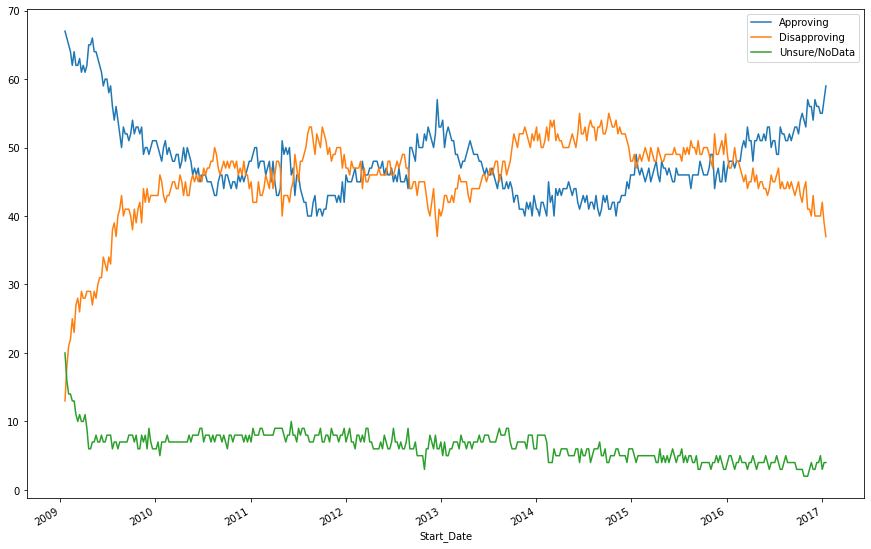

In [62]:
obama_ratings.plot(x="Start_Date", y=["Approving", "Disapproving", "Unsure/NoData"], figsize=(15, 10))
plt.show()

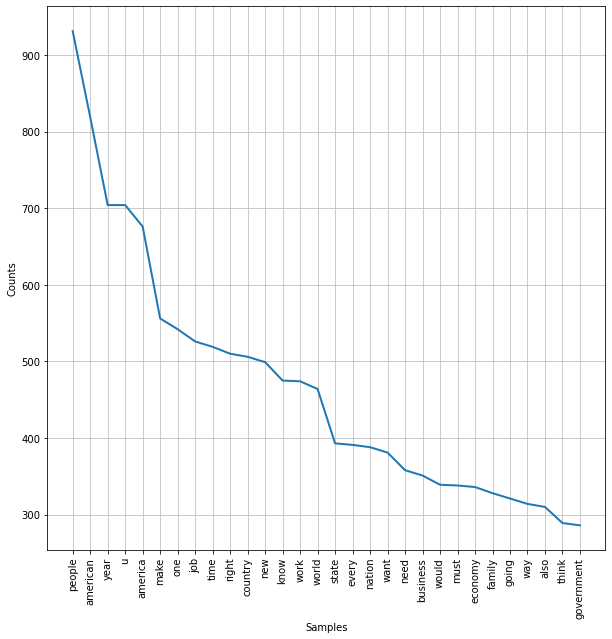

In [63]:
plot_lemmatized(obama_speeches)

# President Trump Speeches and Job Approval Ratings EDA

In [64]:
trump_speeches=new_df[(new_df['President'] == 'Donald Trump')]
trump_speeches.head()

Date     President       Party  \
128 2017-01-20  Donald Trump  Republican   
129 2017-02-28  Donald Trump  Republican   
130 2017-06-29  Donald Trump  Republican   
131 2017-07-24  Donald Trump  Republican   
132 2017-09-19  Donald Trump  Republican   

                                       Speech Title  \
128                               Inaugural Address   
129            Address to Joint Session of Congress   
130  Speech at the Unleashing American Energy Event   
131                Speech at the Boy Scout Jamboree   
132  Address to the United Nations General Assembly   

                                            Transcript  
128  Chief Justice Roberts, President Carter, Presi...  
129  Mr. Speaker, Mr. Vice President, Members of Co...  
130  Thank you, everybody. Thank you very much. How...  
131  TRUMP: Thank you, everybody. Thank you very mu...  
132  Mr. Secretary General, Mr. President, world le...

In [65]:
trump_speeches

Date     President       Party  \
128 2017-01-20  Donald Trump  Republican   
129 2017-02-28  Donald Trump  Republican   
130 2017-06-29  Donald Trump  Republican   
131 2017-07-24  Donald Trump  Republican   
132 2017-09-19  Donald Trump  Republican   
133 2017-12-18  Donald Trump  Republican   
134 2018-01-26  Donald Trump  Republican   
135 2018-01-30  Donald Trump  Republican   
136 2018-02-01  Donald Trump  Republican   
137 2018-02-15  Donald Trump  Republican   
138 2018-02-23  Donald Trump  Republican   
139 2018-03-19  Donald Trump  Republican   
140 2018-07-24  Donald Trump  Republican   
141 2018-09-25  Donald Trump  Republican   
142 2019-01-19  Donald Trump  Republican   
143 2019-02-05  Donald Trump  Republican   
144 2019-02-15  Donald Trump  Republican   
145 2019-09-24  Donald Trump  Republican   
146 2019-09-25  Donald Trump  Republican   

                                          Speech Title  \
128                                  Inaugural Address   
129               Address to Joint Session of Congress   
130     Speech at the Unleashing American Energy Event   
131                   Speech at the Boy Scout Jamboree   
132     Address to the United Nations General Assembly   
133              Remarks on National Security Strategy   
134                Address at the World Economic Forum   
135                         State of the Union Address   
136  Remarks at the House and Senate Republican Mem...   
137  Statement on the School Shooting in Parkland, ...   
138  Remarks at the Conservative Political Action C...   
139             Remarks on Combating the Opioid Crisis   
140  Speech at the Veterans of Foreign Wars Nationa...   
141  Address at the 73rd Session of the United Nati...   
142               Remarks about the US Southern Border   
143                         State of the Union Address   
144              Speech Declaring a National Emergency   
145     Remarks at the United Nations General Assembly   
146                                   Press Conference   

                                            Transcript  
128  Chief Justice Roberts, President Carter, Presi...  
129  Mr. Speaker, Mr. Vice President, Members of Co...  
130  Thank you, everybody. Thank you very much. How...  
131  TRUMP: Thank you, everybody. Thank you very mu...  
132  Mr. Secretary General, Mr. President, world le...  
133  Thank you very much. Thank you. Please. I want...  
134  Thank you, Klaus, very much. It's a privilege ...  
135  Mr. Speaker, Mr. Vice President, Members of Co...  
136  Thank you, Paul and Mitch, for the introductio...  
137  My fellow Americans, today I speak to a nation...  
138  Thank you very much. Thank you everybody. Than...  
139  Thank you to our First Lady, Melania, who has ...  
140  Thank you, Lee. Thank you, Lee. Thank you. And...  
141  Madam President, Mr. Secretary-General, world ...  
142  Just a short time ago, I had the honor of pres...  
143  Madam Speaker, Mr. Vice President, Members of ...  
144  Thank you very much, everybody. Before we begi...  
145  Thank you very much. Mr. President, Mr. Secret...  
146  Thank you very much. Thank you. Well, thank yo...

In [66]:
trump_ratings = pd.read_csv('American Presidency Project - Approval Ratings for POTUS - Donald Trump.csv')
trump_ratings

Start Date    End Date  Approving  Disapproving  Unsure/NoData
0    01/04/2021  01/15/2021         34            62              4
1    12/01/2020  12/17/2020         39            57              4
2    11/05/2020  11/19/2020         43            55              2
3    10/16/2020  10/27/2020         46            52              2
4    09/30/2020  10/15/2020         43            55              2
..          ...         ...        ...           ...            ...
136  02/20/2017  02/26/2017         42            53              5
137  02/13/2017  02/19/2017         40            54              6
138  02/06/2017  02/12/2017         41            53              6
139  01/30/2017  02/05/2017         43            52              5
140  01/20/2017  01/29/2017         45            47              8

[141 rows x 5 columns]

In [67]:
trump_ratings.nunique()

Start Date       141
End Date         141
Approving         15
Disapproving      15
Unsure/NoData      8
dtype: int64

In [68]:
trump_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Start Date     141 non-null    object
 1   End Date       141 non-null    object
 2   Approving      141 non-null    int64 
 3   Disapproving   141 non-null    int64 
 4   Unsure/NoData  141 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 5.6+ KB


In [69]:
trump_ratings.describe()

Approving  Disapproving  Unsure/NoData
count  141.000000    141.000000     141.000000
mean    40.382979     54.907801       4.709220
std      3.118286      2.863317       1.256634
min     34.000000     45.000000       1.000000
25%     38.000000     53.000000       4.000000
50%     40.000000     55.000000       5.000000
75%     42.000000     57.000000       6.000000
max     49.000000     62.000000       8.000000

In [70]:
trump_df = build_clinton(trump_ratings)
trump_df

month_year  Approving  Disapproving  Unsure/NoData  high  low
0     2017-01      45.00         47.00           8.00   0.0  1.0
1     2017-02      41.50         53.00           5.50   0.0  1.0
2     2017-03      41.00         53.50           5.50   0.0  1.0
3     2017-04      40.00         54.00           6.00   0.0  1.0
4     2017-05      39.75         54.75           5.50   0.0  1.0
5     2017-06      38.00         56.75           5.25   0.0  1.0
6     2017-07      38.20         56.80           5.00   0.0  1.0
7     2017-08      36.25         58.50           5.25   0.0  1.0
8     2017-09      37.25         57.00           5.75   0.0  1.0
9     2017-10      36.60         57.80           5.60   0.0  1.0
10    2017-11      37.75         56.75           5.50   0.0  1.0
11    2017-12      36.40         58.00           5.60   0.0  1.0
12    2018-01      37.25         58.00           4.75   0.0  1.0
13    2018-02      39.00         57.25           3.75   0.0  1.0
14    2018-03      39.25         55.50           5.25   0.0  1.0
15    2018-04      40.00         54.60           5.40   0.0  1.0
16    2018-05      41.75         53.25           5.00   0.0  1.0
17    2018-06      42.25         53.50           4.25   0.0  1.0
18    2018-07      41.60         54.00           4.40   0.0  1.0
19    2018-08      40.75         54.00           5.25   0.0  1.0
20    2018-09      40.20         54.40           5.40   0.0  1.0
21    2018-10      42.75         52.00           5.25   0.0  1.0
22    2018-11      39.75         55.75           4.50   0.0  1.0
23    2018-12      39.25         56.00           4.75   0.0  1.0
24    2019-01      37.00         59.00           4.00   0.0  1.0
25    2019-02      43.50         53.00           3.50   0.0  1.0
26    2019-03      39.00         57.00           4.00   0.0  1.0
27    2019-04      45.50         50.50           4.00   0.0  1.0
28    2019-05      41.00         53.50           5.50   0.0  1.0
29    2019-06      42.00         54.50           3.50   0.0  1.0
30    2019-07      43.00         52.50           4.50   0.0  1.0
31    2019-08      40.00         55.50           4.50   0.0  1.0
32    2019-09      41.50         55.00           3.50   0.0  1.0
33    2019-10      40.00         57.00           3.00   0.0  1.0
34    2019-11      43.00         54.00           3.00   0.0  1.0
35    2019-12      45.00         51.00           4.00   0.0  1.0
36    2020-01      46.50         51.50           2.00   0.0  1.0
37    2020-02      48.00         49.50           2.50   0.0  1.0
38    2020-03      46.50         48.50           5.00   0.0  1.0
39    2020-04      46.00         50.50           3.50   0.0  1.0
40    2020-05      49.00         48.00           3.00   0.0  1.0
41    2020-06      38.50         57.00           4.50   0.0  1.0
42    2020-07      41.00         56.00           3.00   0.0  1.0
43    2020-08      42.00         55.00           3.00   0.0  1.0
44    2020-09      44.00         54.00           2.00   0.0  1.0
45    2020-10      44.50         53.50           2.00   0.0  1.0
46    2020-11      43.00         55.00           2.00   0.0  1.0
47    2020-12      39.00         57.00           4.00   0.0  1.0
48    2021-01      34.00         62.00           4.00   0.0  1.0

In [71]:
new_trump_df = merge_trump_df(trump_speeches)
new_trump_df

<ipython-input-9-2a1f02736d1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_ratings['month_year'] = pd.to_datetime(speeches_ratings['Date']).dt.to_period('M')


month_year  Approving  Disapproving  Unsure/NoData  high  low       Date  \
0     2017-01         45            47              8     0    1 2017-01-20   
1     2017-02         41            53              5     0    1 2017-02-28   
2     2017-06         38            56              5     0    1 2017-06-29   
3     2017-07         38            56              5     0    1 2017-07-24   
4     2017-09         37            57              5     0    1 2017-09-19   
5     2017-12         36            58              5     0    1 2017-12-18   
6     2018-01         37            58              4     0    1 2018-01-26   
7     2018-01         37            58              4     0    1 2018-01-30   
8     2018-02         39            57              3     0    1 2018-02-01   
9     2018-02         39            57              3     0    1 2018-02-15   
10    2018-02         39            57              3     0    1 2018-02-23   
11    2018-03         39            55              5     0    1 2018-03-19   
12    2018-07         41            54              4     0    1 2018-07-24   
13    2018-09         40            54              5     0    1 2018-09-25   
14    2019-01         37            59              4     0    1 2019-01-19   
15    2019-02         43            53              3     0    1 2019-02-05   
16    2019-02         43            53              3     0    1 2019-02-15   
17    2019-09         41            55              3     0    1 2019-09-24   
18    2019-09         41            55              3     0    1 2019-09-25   

       President       Party  \
0   Donald Trump  Republican   
1   Donald Trump  Republican   
2   Donald Trump  Republican   
3   Donald Trump  Republican   
4   Donald Trump  Republican   
5   Donald Trump  Republican   
6   Donald Trump  Republican   
7   Donald Trump  Republican   
8   Donald Trump  Republican   
9   Donald Trump  Republican   
10  Donald Trump  Republican   
11  Donald Trump  Republican   
12  Donald Trump  Republican   
13  Donald Trump  Republican   
14  Donald Trump  Republican   
15  Donald Trump  Republican   
16  Donald Trump  Republican   
17  Donald Trump  Republican   
18  Donald Trump  Republican   

                                         Speech Title  \
0                                   Inaugural Address   
1                Address to Joint Session of Congress   
2      Speech at the Unleashing American Energy Event   
3                    Speech at the Boy Scout Jamboree   
4      Address to the United Nations General Assembly   
5               Remarks on National Security Strategy   
6                 Address at the World Economic Forum   
7                          State of the Union Address   
8   Remarks at the House and Senate Republican Mem...   
9   Statement on the School Shooting in Parkland, ...   
10  Remarks at the Conservative Political Action C...   
11             Remarks on Combating the Opioid Crisis   
12  Speech at the Veterans of Foreign Wars Nationa...   
13  Address at the 73rd Session of the United Nati...   
14               Remarks about the US Southern Border   
15                         State of the Union Address   
16              Speech Declaring a National Emergency   
17     Remarks at the United Nations General Assembly   
18                                   Press Conference   

                                           Transcript  
0   Chief Justice Roberts, President Carter, Presi...  
1   Mr. Speaker, Mr. Vice President, Members of Co...  
2   Thank you, everybody. Thank you very much. How...  
3   TRUMP: Thank you, everybody. Thank you very mu...  
4   Mr. Secretary General, Mr. President, world le...  
5   Thank you very much. Thank you. Please. I want...  
6   Thank you, Klaus, very much. It's a privilege ...  
7   Mr. Speaker, Mr. Vice President, Members of Co...  
8   Thank you, Paul and Mitch, for the introductio...  
9   My fellow Americans, today I speak to a nation...  
10  Thank you very much.

In [72]:
new_trump_df.shape

(19, 11)

President Trump's job approval ratings while in office:

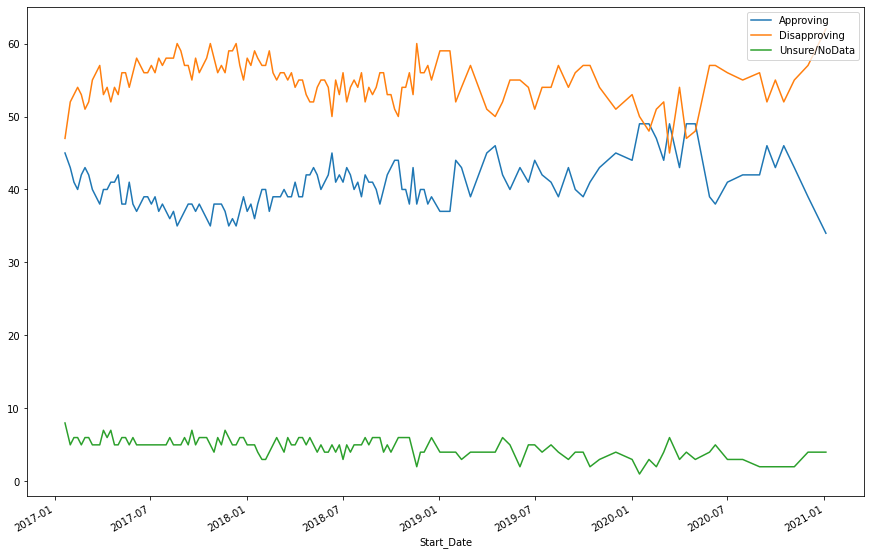

In [73]:
trump_ratings.plot(x="Start_Date", y=["Approving", "Disapproving", "Unsure/NoData"], figsize=(15, 10))
plt.legend(loc='upper right')
plt.show()

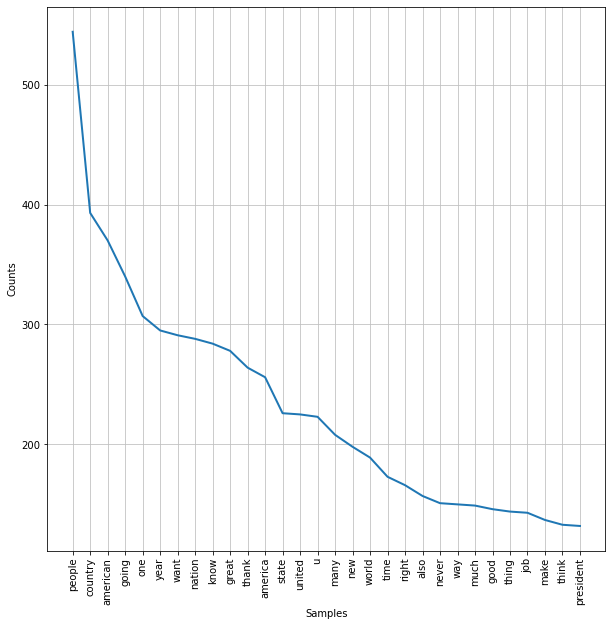

In [74]:
plot_lemmatized(trump_speeches)

# Combined DataFrames of Presidential Speeches and Job Approval Ratings

In [75]:
combined_df = [new_clinton_df, new_bush_df, new_obama_df, new_trump_df]
presidential_df = pd.concat(combined_df)
presidential_df.head()

month_year  Approving  Disapproving  Unsure/NoData  high  low       Date  \
0    1993-01         56            25             19     1    0 1993-01-20   
1    1993-01         56            25             19     1    0 1993-01-29   
2    1993-02         55            31             13     1    0 1993-02-05   
3    1993-02         55            31             13     1    0 1993-02-17   
4    1993-04         55            37              8     1    0 1993-04-30   

      President       Party  \
0  Bill Clinton  Democratic   
1  Bill Clinton  Democratic   
2  Bill Clinton  Democratic   
3  Bill Clinton  Democratic   
4  Bill Clinton  Democratic   

                                        Speech Title  \
0                                    First Inaugural   
1         Press Conference on "Gays in the Military"   
2  Remarks at the Signing of the Family Medical L...   
3         Address Before a Joint Session of Congress   
4                           National Service Address   

                                          Transcript  
0  My fellow citizens, today we celebrate the mys...  
1  The President. Good afternoon, ladies and gent...  
2  Thank you very much, thank you. Mrs. Yandle, I...  
3  Mr. President, Mr. Speaker, Members of the Hou...  
4  It is wonderful to be back in New Orleans and ...

In [76]:
presidential_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 18
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   month_year     143 non-null    period[M]     
 1   Approving      143 non-null    int64         
 2   Disapproving   143 non-null    int64         
 3   Unsure/NoData  143 non-null    int64         
 4   high           143 non-null    int64         
 5   low            143 non-null    int64         
 6   Date           143 non-null    datetime64[ns]
 7   President      143 non-null    object        
 8   Party          143 non-null    object        
 9   Speech Title   143 non-null    object        
 10  Transcript     143 non-null    object        
dtypes: datetime64[ns](1), int64(5), object(4), period[M](1)
memory usage: 13.4+ KB


In [77]:
presidential_df['high'] = presidential_df['high'].astype(int)

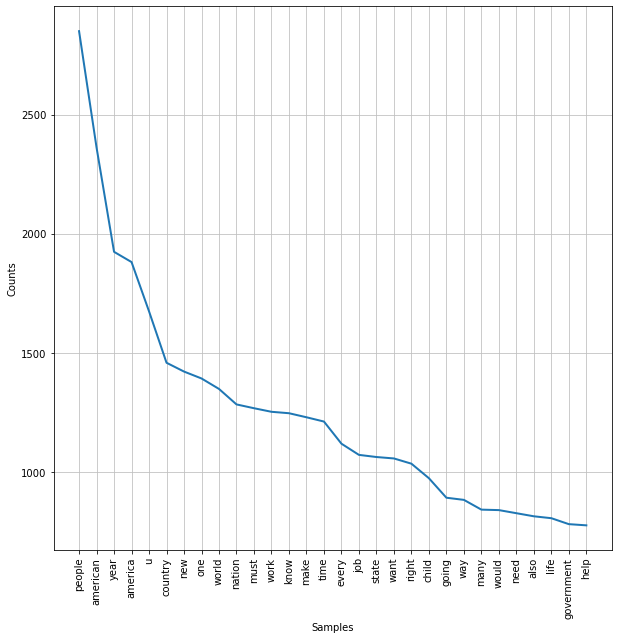

In [78]:
plot_lemmatized(presidential_df)

# Word Associations

In this section, using the combined presidential dataframe, I created subsets focusing on speeches connected to high and low presidential ratings, as well as party affiliation. Note: the lemmatization of the word 'us' is 'u'. For statistical purposes 'u' has not been taken out of the bag of words because of its high frequency among the speeches in this dataset and its relevance among the other words.

In [79]:
high_presidential_df = presidential_df[presidential_df['high'] == 1]
high_presidential_df.head()

month_year  Approving  Disapproving  Unsure/NoData  high  low       Date  \
0    1993-01         56            25             19     1    0 1993-01-20   
1    1993-01         56            25             19     1    0 1993-01-29   
2    1993-02         55            31             13     1    0 1993-02-05   
3    1993-02         55            31             13     1    0 1993-02-17   
4    1993-04         55            37              8     1    0 1993-04-30   

      President       Party  \
0  Bill Clinton  Democratic   
1  Bill Clinton  Democratic   
2  Bill Clinton  Democratic   
3  Bill Clinton  Democratic   
4  Bill Clinton  Democratic   

                                        Speech Title  \
0                                    First Inaugural   
1         Press Conference on "Gays in the Military"   
2  Remarks at the Signing of the Family Medical L...   
3         Address Before a Joint Session of Congress   
4                           National Service Address   

                                          Transcript  
0  My fellow citizens, today we celebrate the mys...  
1  The President. Good afternoon, ladies and gent...  
2  Thank you very much, thank you. Mrs. Yandle, I...  
3  Mr. President, Mr. Speaker, Members of the Hou...  
4  It is wonderful to be back in New Orleans and ...

In [80]:
low_presidential_df = presidential_df[presidential_df['high'] == 0]
low_presidential_df.head()

month_year  Approving  Disapproving  Unsure/NoData  high  low       Date  \
5    1993-05         44            45             10     0    1 1993-05-05   
6    1993-06         40            48             10     0    1 1993-06-06   
7    1993-09         49            40             10     0    0 1993-09-13   
8    1993-09         49            40             10     0    0 1993-09-22   
9    1993-10         48            43              8     0    0 1993-10-07   

      President       Party  \
5  Bill Clinton  Democratic   
6  Bill Clinton  Democratic   
7  Bill Clinton  Democratic   
8  Bill Clinton  Democratic   
9  Bill Clinton  Democratic   

                                        Speech Title  \
5                  Remarks on Operation Restore Hope   
6  Speech at the 25th Anniversary Memorial Mass f...   
7  Remarks at the Signing of the Israeli-Palestin...   
8                      Address on Health Care Reform   
9                                 Address on Somalia   

                                          Transcript  
5  To all of our distinguished guests from all th...  
6  Father Creedon, Mrs. Kennedy, the children of ...  
7  Prime Minister Rabin, Chairman Arafat, Foreign...  
8  Mr. Speaker, Mr. President, Members of Congres...  
9  My fellow Americans: Today I want to talk with...

In [81]:
democrat_df = presidential_df[presidential_df['Party'] == 'Democratic']
republican_df = presidential_df[presidential_df['Party'] == 'Republican']

In [82]:
cs = return_lemmatized(clinton_speeches)
bs = return_lemmatized(bush_speeches)
os = return_lemmatized(obama_speeches)
ts = return_lemmatized(trump_speeches)
pres_high = return_lemmatized(high_presidential_df)
pres_low = return_lemmatized(low_presidential_df)
demo = return_lemmatized(democrat_df)
rep = return_lemmatized(republican_df)

In [83]:
from collections import Counter

In [84]:
cs_words = Counter(cs)
bs_words = Counter(bs)
os_words = Counter(os)
ts_words = Counter(ts)
high_words = Counter(pres_high)
low_words = Counter(pres_low)
demo_words = Counter(demo)
rep_words = Counter(rep)

In [85]:
clinton_top_words = dict(sorted(cs_words.items(), key=lambda item: item[1], reverse=True)[:25])
bush_top_words = dict(sorted(bs_words.items(), key=lambda item: item[1], reverse=True)[:25])
obama_top_words = dict(sorted(os_words.items(), key=lambda item: item[1], reverse=True)[:25])
trump_top_words = dict(sorted(ts_words.items(), key=lambda item: item[1], reverse=True)[:25])
high_top_words = dict(sorted(high_words.items(), key=lambda item: item[1], reverse=True)[:25])
low_top_words = dict(sorted(low_words.items(), key=lambda item: item[1], reverse=True)[:25])
demo_top_words = dict(sorted(demo_words.items(), key=lambda item: item[1], reverse=True)[:25])
rep_top_words = dict(sorted(rep_words.items(), key=lambda item: item[1], reverse=True)[:25])

## Clinton Word Count

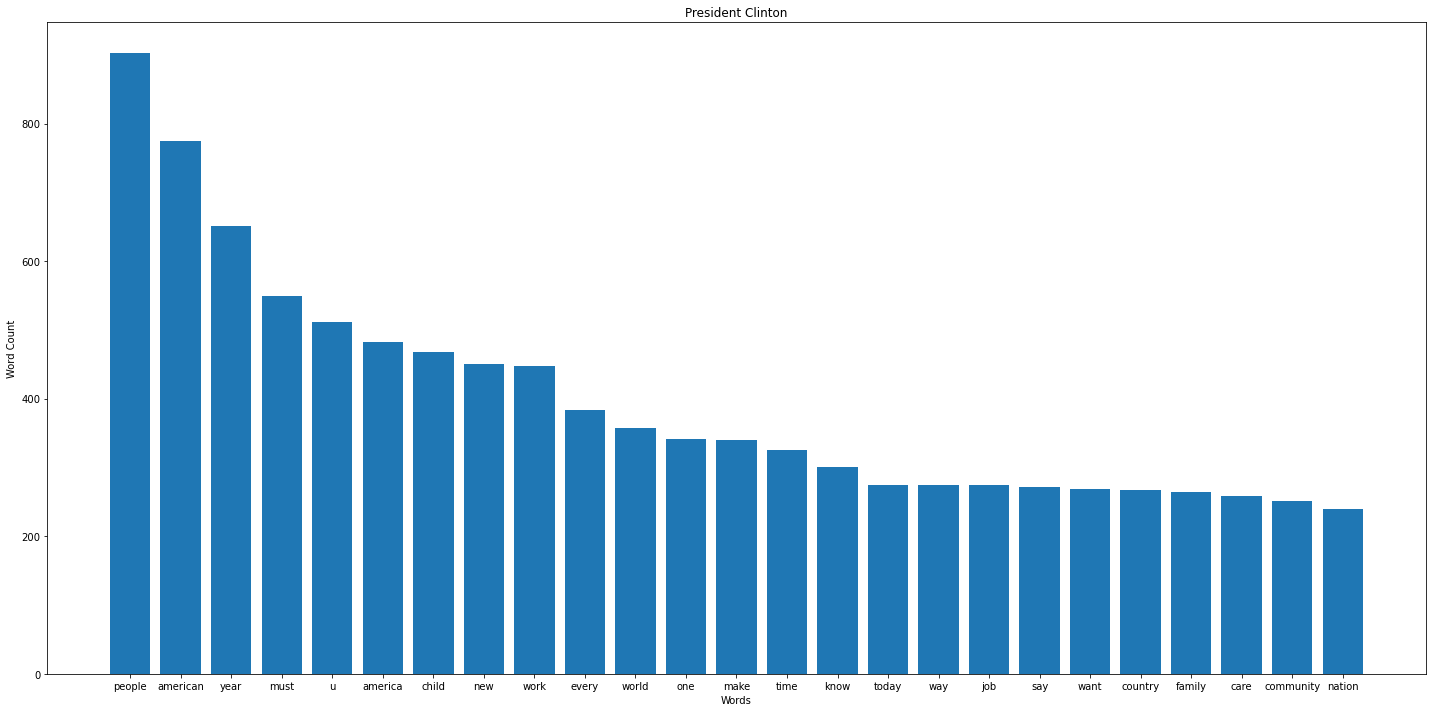

In [86]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = clinton_top_words.keys()
values = clinton_top_words.values()
plt.xlabel("Words")
plt.ylabel("Word Count")
plt.title('President Clinton')
plt.bar(keys, values);

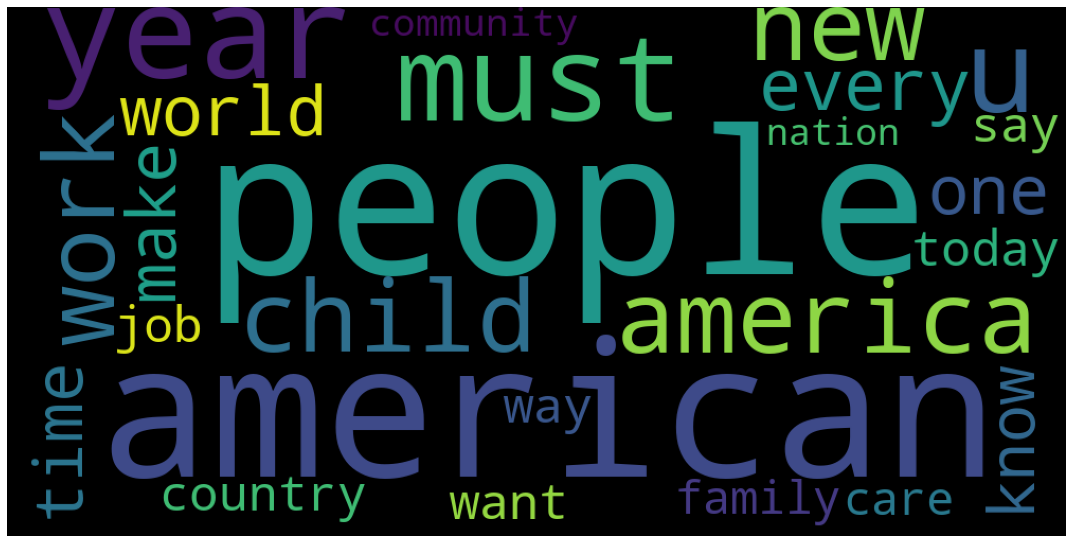

In [87]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(clinton_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

## Bush Word Count

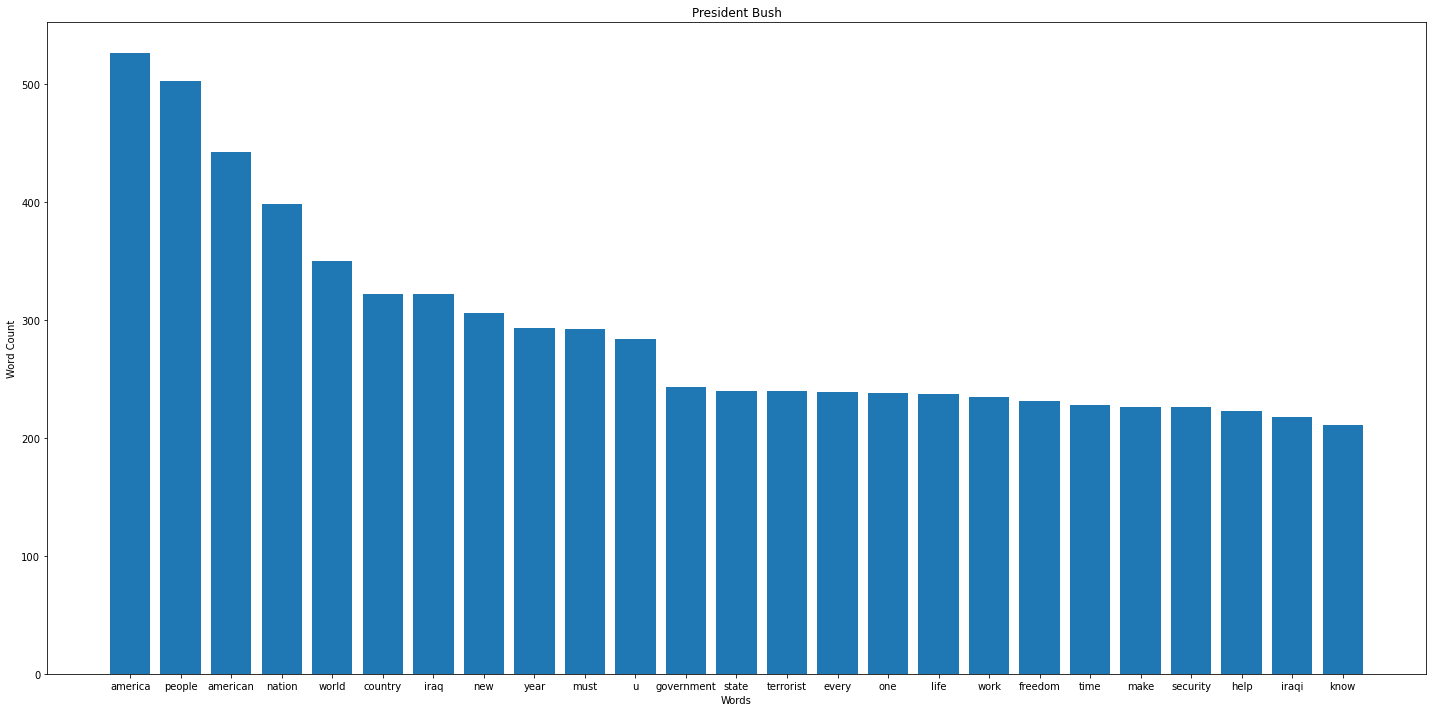

In [88]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = bush_top_words.keys()
values = bush_top_words.values()
plt.xlabel("Words")
plt.ylabel("Word Count")
plt.title("President Bush")
plt.bar(keys, values);

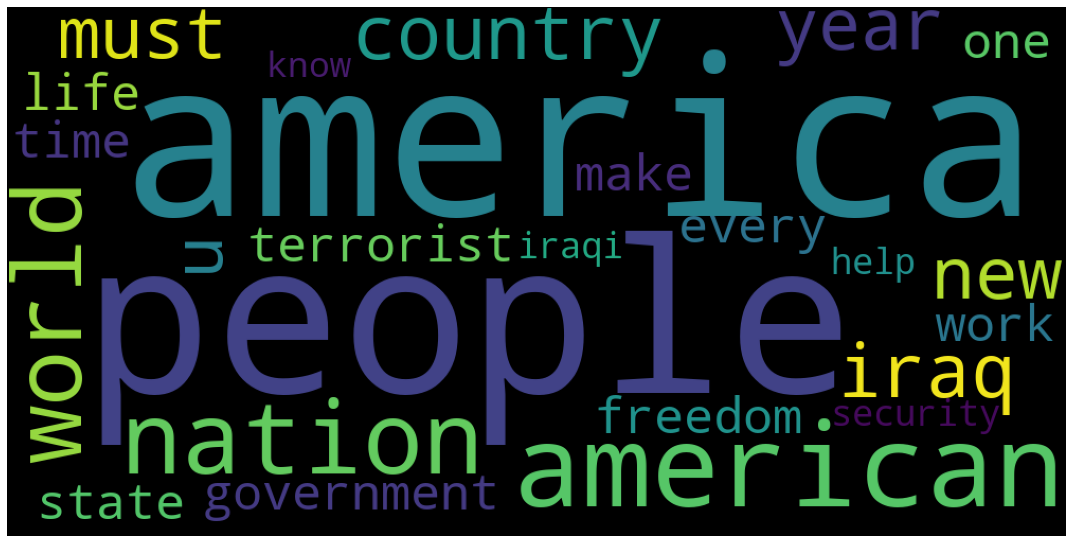

In [89]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(bush_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

## Obama Word Count

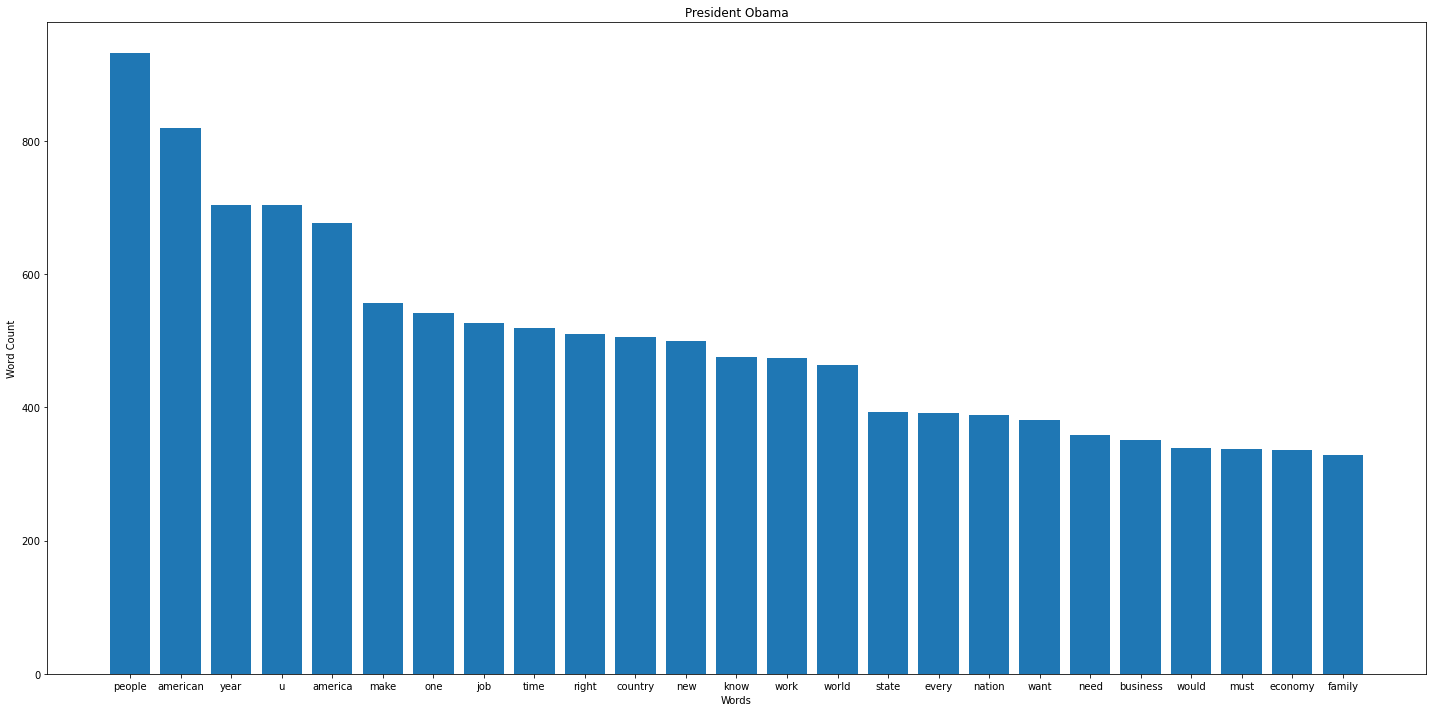

In [90]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = obama_top_words.keys()
values = obama_top_words.values()
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('President Obama')
plt.bar(keys, values);

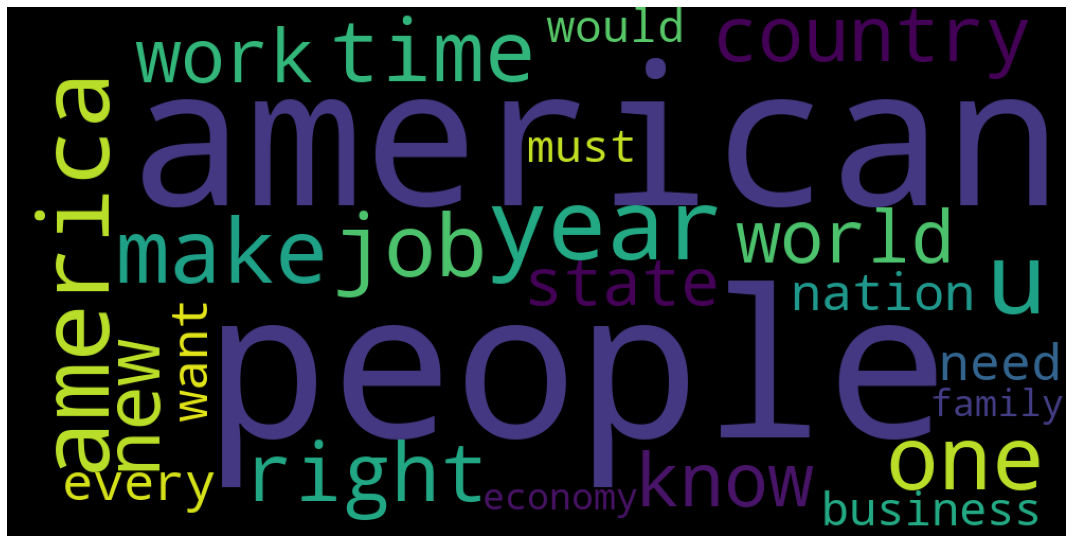

In [91]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(obama_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

## Trump Word Count

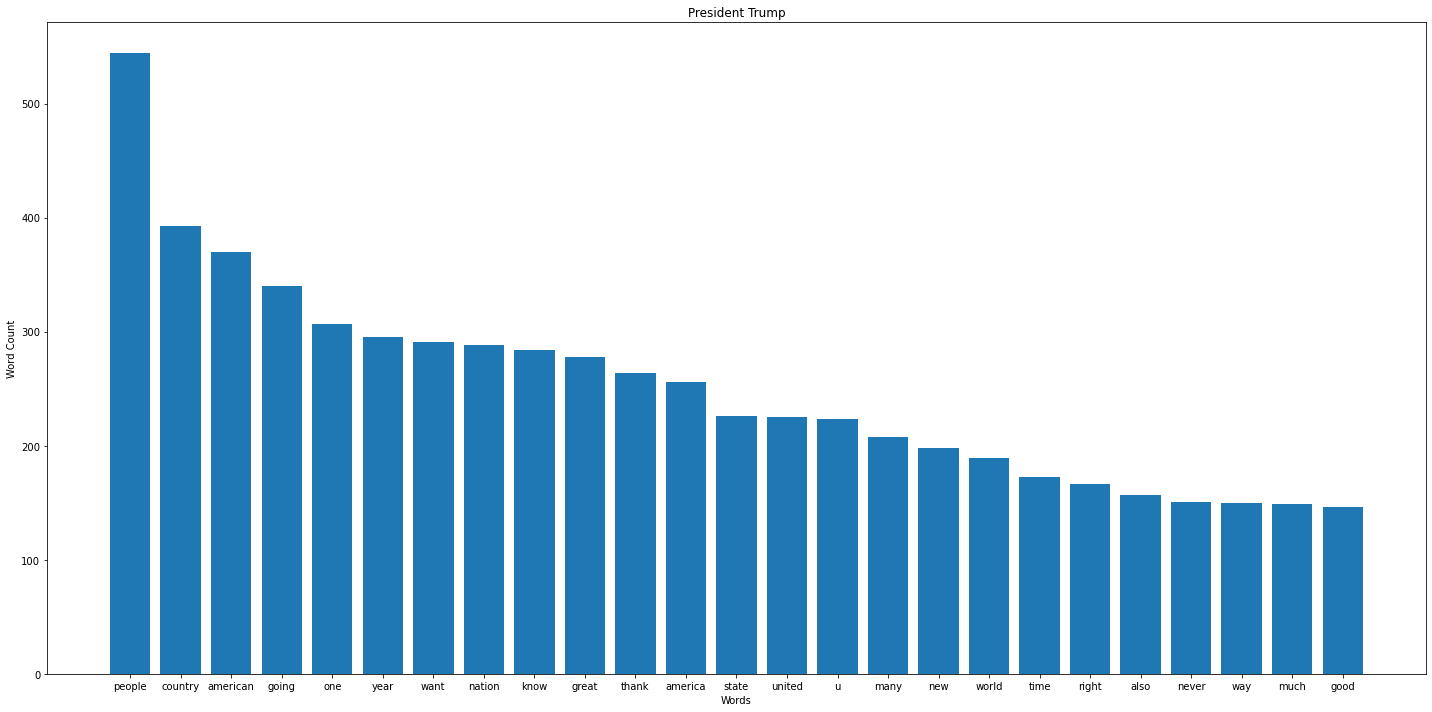

In [92]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = trump_top_words.keys()
values = trump_top_words.values()
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('President Trump')
plt.bar(keys, values);

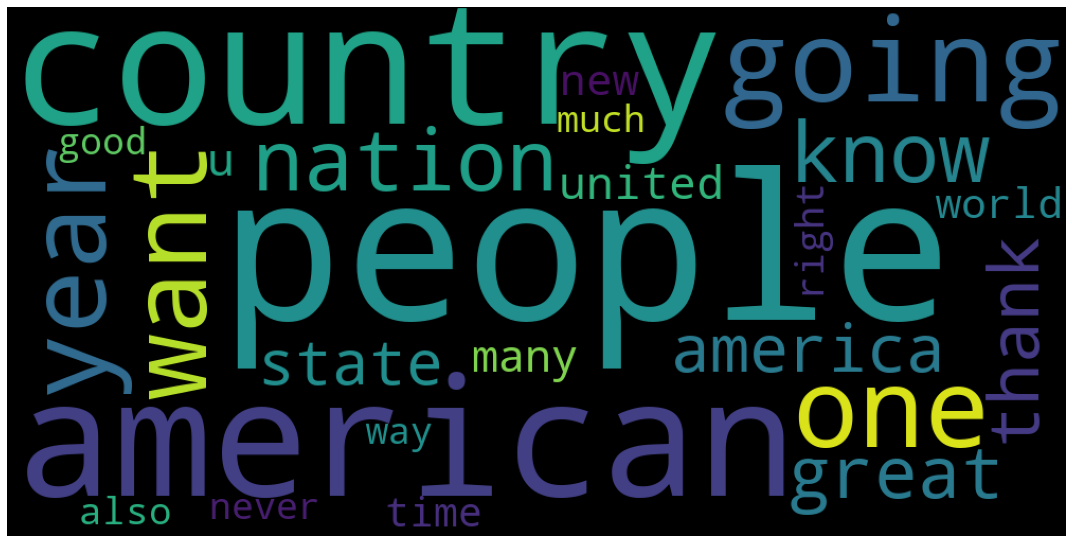

In [93]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(trump_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

## Democrat Word Count

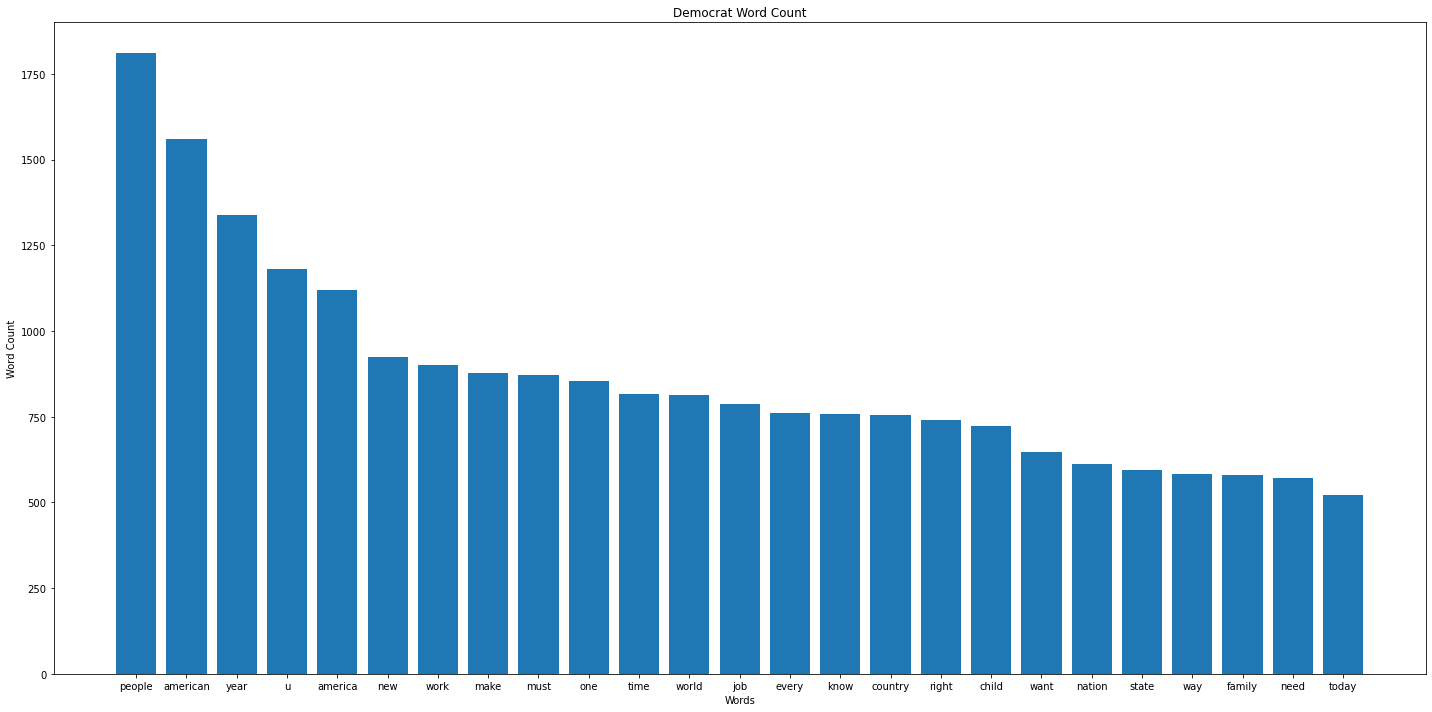

In [94]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = demo_top_words.keys()
values = demo_top_words.values()
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('Democrat Word Count')
plt.bar(keys, values);

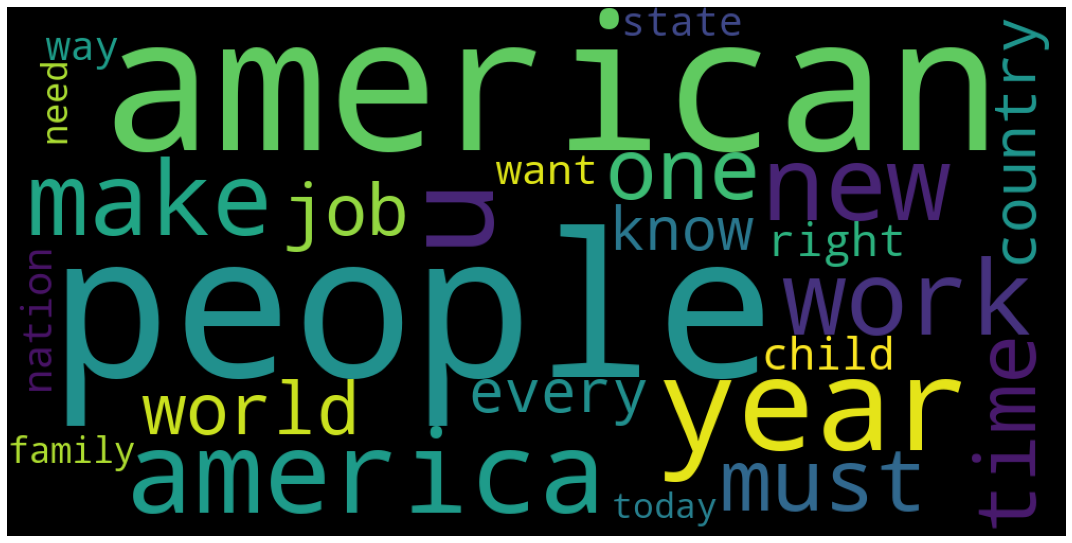

In [95]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(demo_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

## Republican Word Count

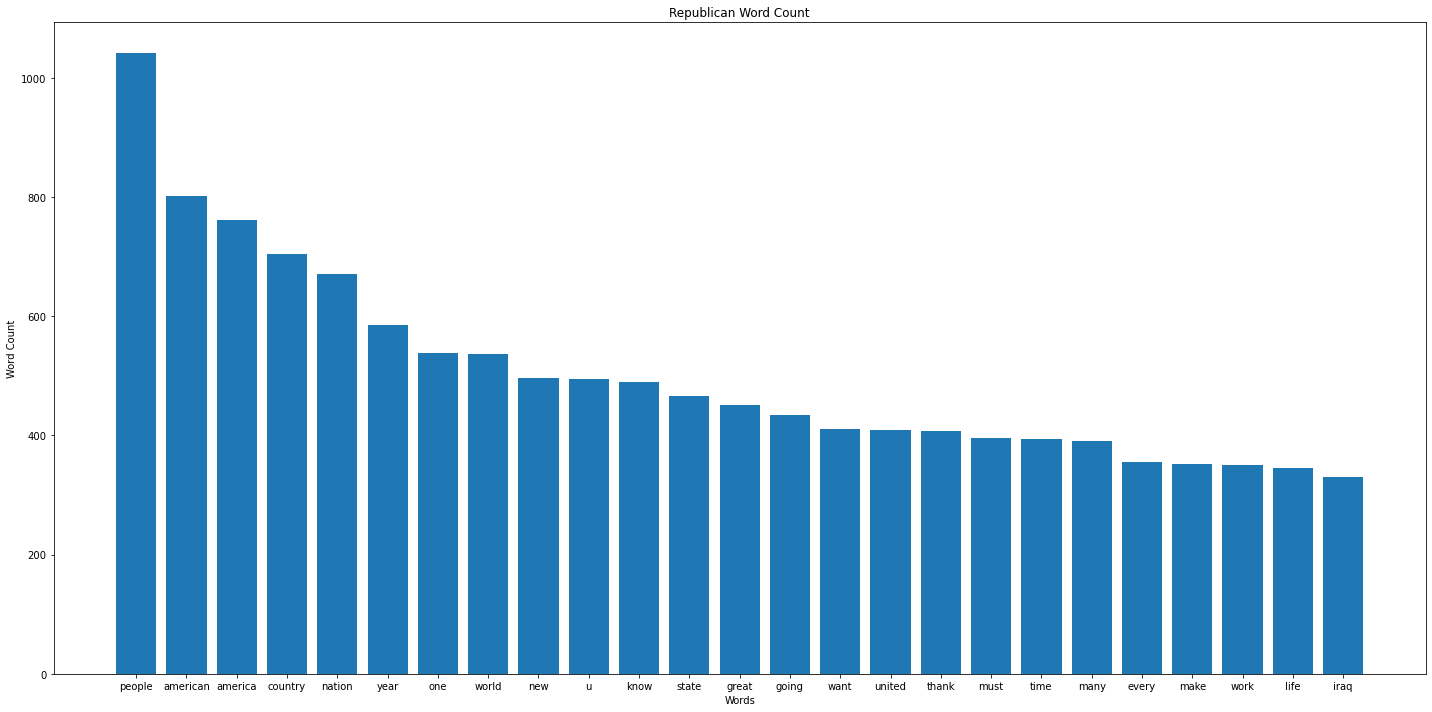

In [96]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = rep_top_words.keys()
values = rep_top_words.values()
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('Republican Word Count')
plt.bar(keys, values);

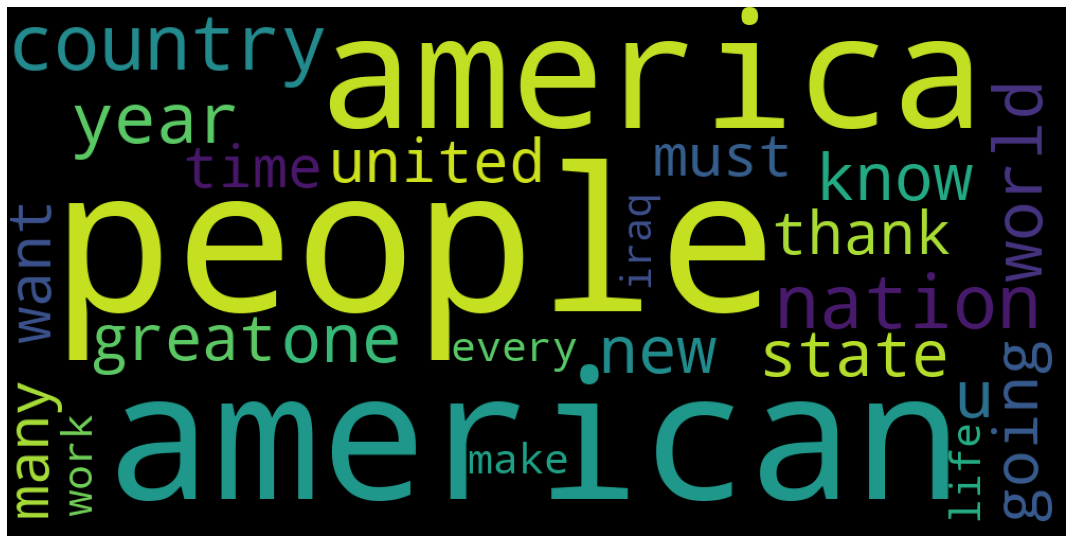

In [97]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(rep_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

There are 83 speeches associated with low job approval ratings, and 60 speeches associated with high job approval ratings. As the bar plots below illustrate, words such as 'must' and 'child' are emphasized more in speeches associated with high job approval ratings, while terms such as 'country' and 'job' are more frequent in speeches associated with low job approval ratings.

## High Job Approval Rating Word Count

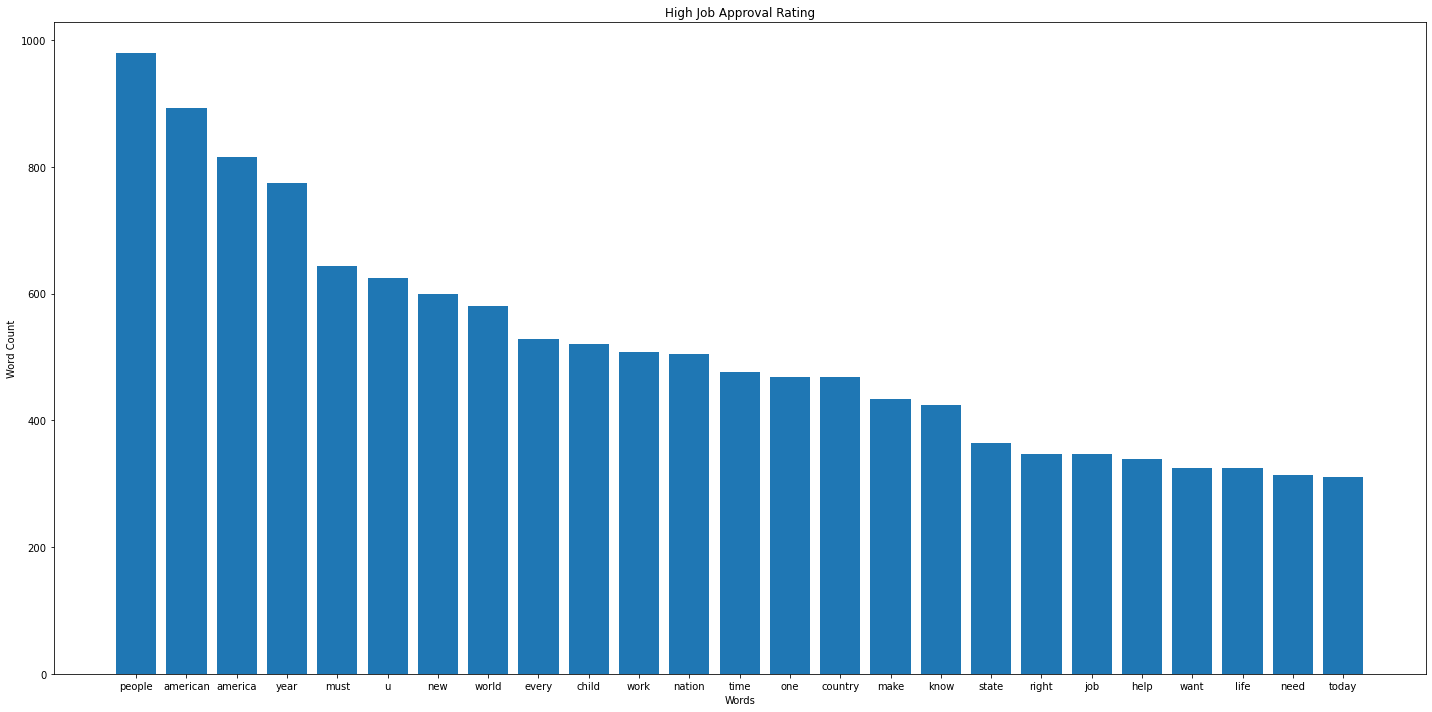

In [98]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = high_top_words.keys()
values = high_top_words.values()
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('High Job Approval Rating')
plt.bar(keys, values);

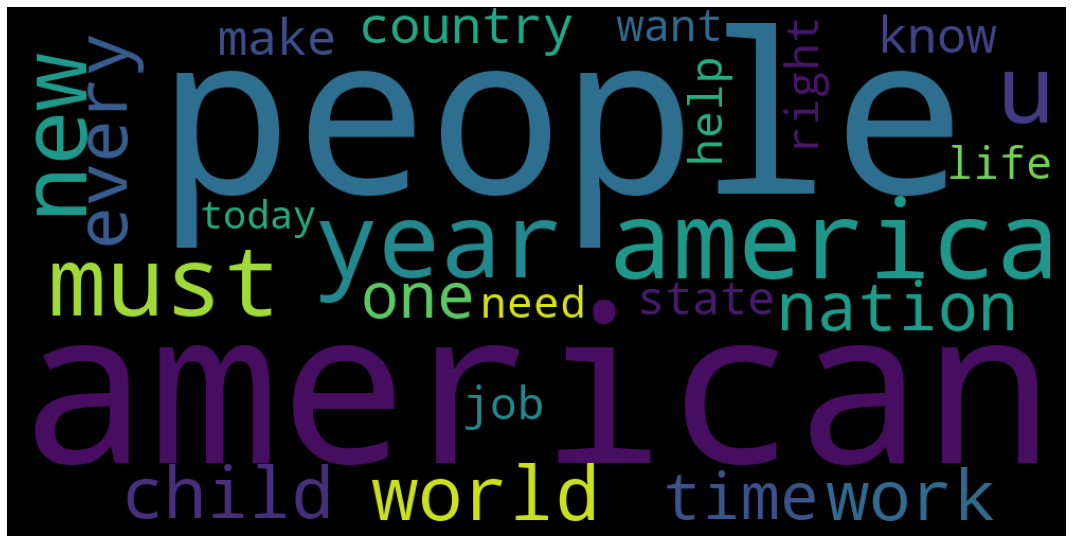

In [99]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(high_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

In [100]:
high_top_words

{'people': 979,
 'american': 893,
 'america': 816,
 'year': 774,
 'must': 643,
 'u': 625,
 'new': 600,
 'world': 580,
 'every': 528,
 'child': 521,
 'work': 508,
 'nation': 505,
 'time': 477,
 'one': 469,
 'country': 468,
 'make': 433,
 'know': 424,
 'state': 365,
 'right': 347,
 'job': 347,
 'help': 339,
 'want': 325,
 'life': 324,
 'need': 314,
 'today': 310}

## Low Job Approval Rating Word Count

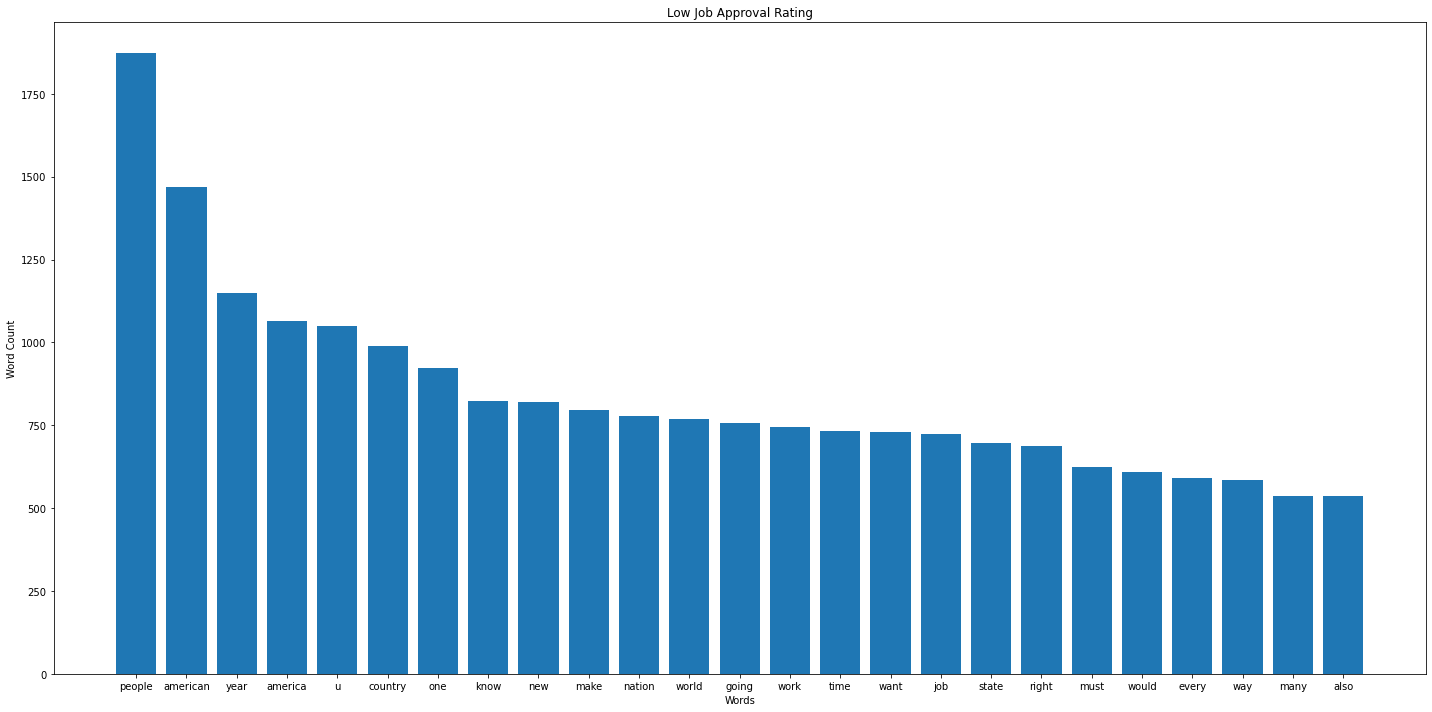

In [101]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
keys = low_top_words.keys()
values = low_top_words.values()
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('Low Job Approval Rating')
plt.bar(keys, values);

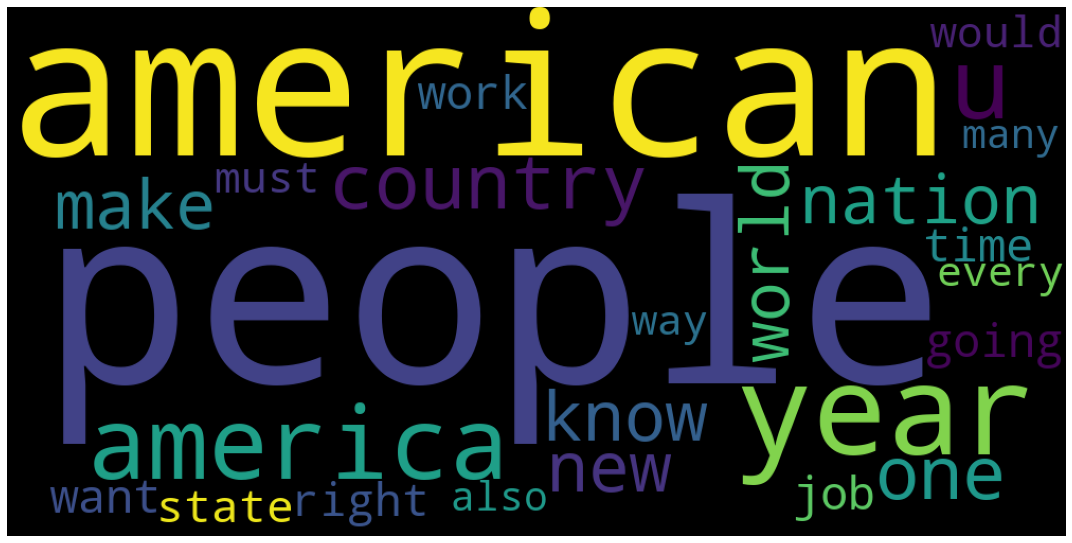

In [102]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(low_top_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()

In [103]:
low_top_words

{'people': 1872,
 'american': 1469,
 'year': 1150,
 'america': 1065,
 'u': 1049,
 'country': 990,
 'one': 923,
 'know': 822,
 'new': 821,
 'make': 796,
 'nation': 778,
 'world': 768,
 'going': 757,
 'work': 744,
 'time': 734,
 'want': 731,
 'job': 724,
 'state': 697,
 'right': 687,
 'must': 624,
 'would': 610,
 'every': 590,
 'way': 584,
 'many': 537,
 'also': 536}

# Initial Models

The models below were created to predict high job approval ratings using the transcripts of the speeches of the presidents in the dataset:

In [104]:
presidential_data = presidential_df['Transcript']
presidential_target = presidential_df['high']

In [105]:
processed_data = [d.split() for d in presidential_data.to_list()]
print(processed_data[:2])

[['My', 'fellow', 'citizens,', 'today', 'we', 'celebrate', 'the', 'mystery', 'of', 'American', 'renewal.', 'This', 'ceremony', 'is', 'held', 'in', 'the', 'depth', 'of', 'winter,', 'but', 'by', 'the', 'words', 'we', 'speak', 'and', 'the', 'faces', 'we', 'show', 'the', 'world,', 'we', 'force', 'the', 'spring,', 'a', 'spring', 'reborn', 'in', 'the', "world's", 'oldest', 'democracy', 'that', 'brings', 'forth', 'the', 'vision', 'and', 'courage', 'to', 'reinvent', 'America.', 'When', 'our', 'Founders', 'boldly', 'declared', "America's", 'independence', 'to', 'the', 'world', 'and', 'our', 'purposes', 'to', 'the', 'Almighty,', 'they', 'knew', 'that', 'America,', 'to', 'endure,', 'would', 'have', 'to', 'change;', 'not', 'change', 'for', "change's", 'sake', 'but', 'change', 'to', 'preserve', "America's", 'ideals:', 'life,', 'liberty,', 'the', 'pursuit', 'of', 'happiness.', 'Though', 'we', 'marched', 'to', 'the', 'music', 'of', 'our', 'time,', 'our', 'mission', 'is', 'timeless.', 'Each', 'generat

In [106]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update([c.lower() for c in comment])
len(total_vocab)

27840

In [107]:
lemmatizer = WordNetLemmatizer()

In [108]:
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [109]:
lemmatized_output[0]

"My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in the depth of winter, but by the word we speak and the face we show the world, we force the spring, a spring reborn in the world's oldest democracy that brings forth the vision and courage to reinvent America. When our Founders boldly declared America's independence to the world and our purpose to the Almighty, they knew that America, to endure, would have to change; not change for change's sake but change to preserve America's ideals: life, liberty, the pursuit of happiness. Though we marched to the music of our time, our mission is timeless. Each generation of Americans must define what it mean to be an American. On behalf of our Nation, I salute my predecessor, President Bush, for his half-century of service to America. And I thank the million of men and woman whose steadfastness and sacrifice triumphed over depression, fascism, and communism. Today, a generation raised in the shadow of 

In [110]:
X_lem = lemmatized_output

y_lem = presidential_target

In [111]:
X_lem

["My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in the depth of winter, but by the word we speak and the face we show the world, we force the spring, a spring reborn in the world's oldest democracy that brings forth the vision and courage to reinvent America. When our Founders boldly declared America's independence to the world and our purpose to the Almighty, they knew that America, to endure, would have to change; not change for change's sake but change to preserve America's ideals: life, liberty, the pursuit of happiness. Though we marched to the music of our time, our mission is timeless. Each generation of Americans must define what it mean to be an American. On behalf of our Nation, I salute my predecessor, President Bush, for his half-century of service to America. And I thank the million of men and woman whose steadfastness and sacrifice triumphed over depression, fascism, and communism. Today, a generation raised in the shadow of

## K-Nearest Neighbors

              precision    recall  f1-score   support

           0       0.76      0.92      0.84        66
           1       0.85      0.60      0.71        48

    accuracy                           0.79       114
   macro avg       0.81      0.76      0.77       114
weighted avg       0.80      0.79      0.78       114

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        17
           1       0.70      0.58      0.64        12

    accuracy                           0.72        29
   macro avg       0.72      0.70      0.71        29
weighted avg       0.72      0.72      0.72        29



KNeighborsClassifier()

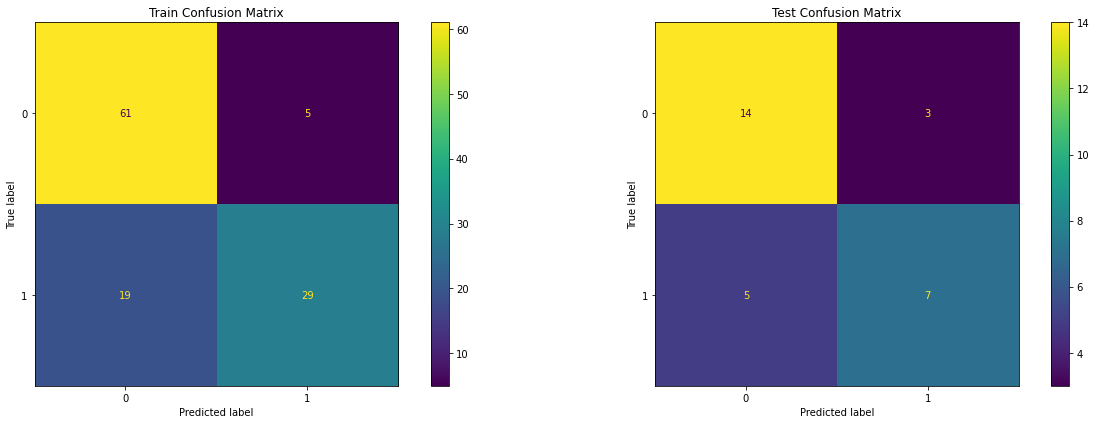

In [135]:
KNN_model = KNeighborsClassifier()

run_model(KNN_model, X_lem, y_lem)

## Bagging Tree

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        66
           1       1.00      0.96      0.98        48

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        17
           1       1.00      0.17      0.29        12

    accuracy                           0.66        29
   macro avg       0.81      0.58      0.53        29
weighted avg       0.78      0.66      0.57        29



BaggingClassifier()

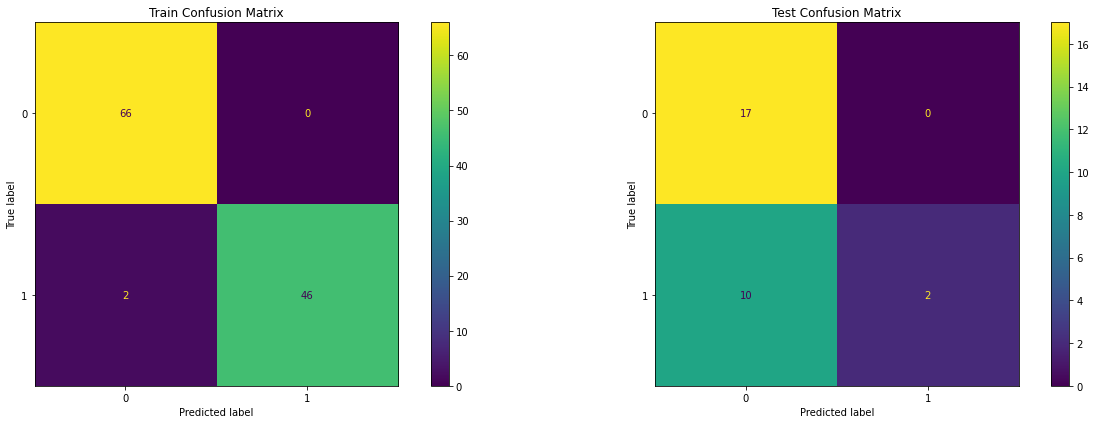

In [113]:
Btree_model = BaggingClassifier()

run_model(Btree_model, X_lem, y_lem)

## RandomForest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        48

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

              precision    recall  f1-score   support

           0       0.64      0.94      0.76        17
           1       0.75      0.25      0.38        12

    accuracy                           0.66        29
   macro avg       0.70      0.60      0.57        29
weighted avg       0.69      0.66      0.60        29



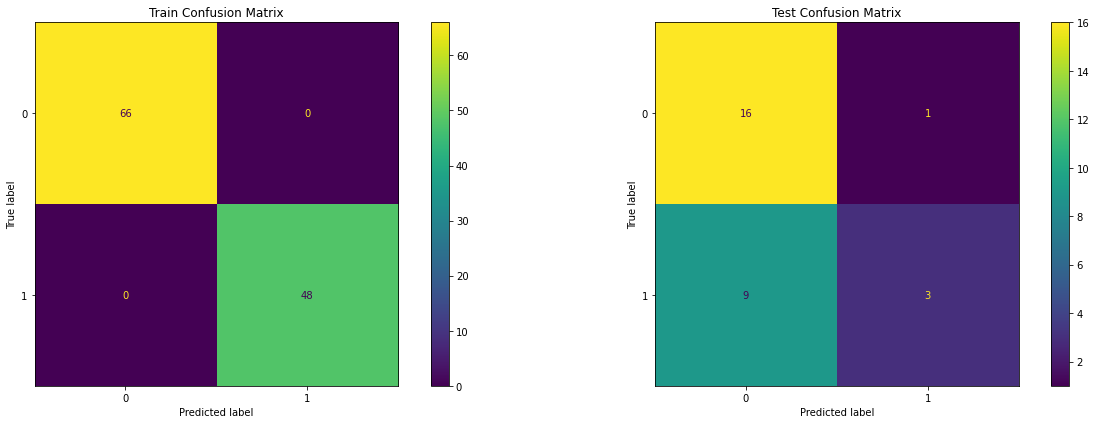

In [114]:
rf_classifier_lem = RandomForestClassifier()

rf_model = run_model(rf_classifier_lem, X_lem, y_lem)

## Naive Bayes

              precision    recall  f1-score   support

           0       0.60      1.00      0.75        66
           1       1.00      0.08      0.15        48

    accuracy                           0.61       114
   macro avg       0.80      0.54      0.45       114
weighted avg       0.77      0.61      0.50       114

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        17
           1       0.00      0.00      0.00        12

    accuracy                           0.59        29
   macro avg       0.29      0.50      0.37        29
weighted avg       0.34      0.59      0.43        29



/Users/mohamedhassan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB()

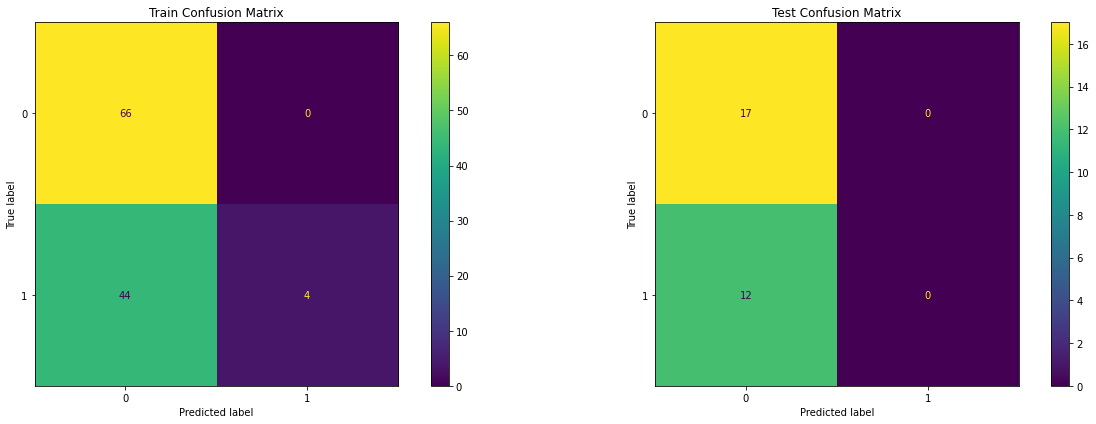

In [115]:
naive_bayes_lem = MultinomialNB()

run_model(naive_bayes_lem, X_lem, y_lem)

## Logistic Regression

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        66
           1       1.00      0.81      0.90        48

    accuracy                           0.92       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.92      0.92       114

              precision    recall  f1-score   support

           0       0.62      0.94      0.74        17
           1       0.67      0.17      0.27        12

    accuracy                           0.62        29
   macro avg       0.64      0.55      0.51        29
weighted avg       0.64      0.62      0.55        29



LogisticRegression()

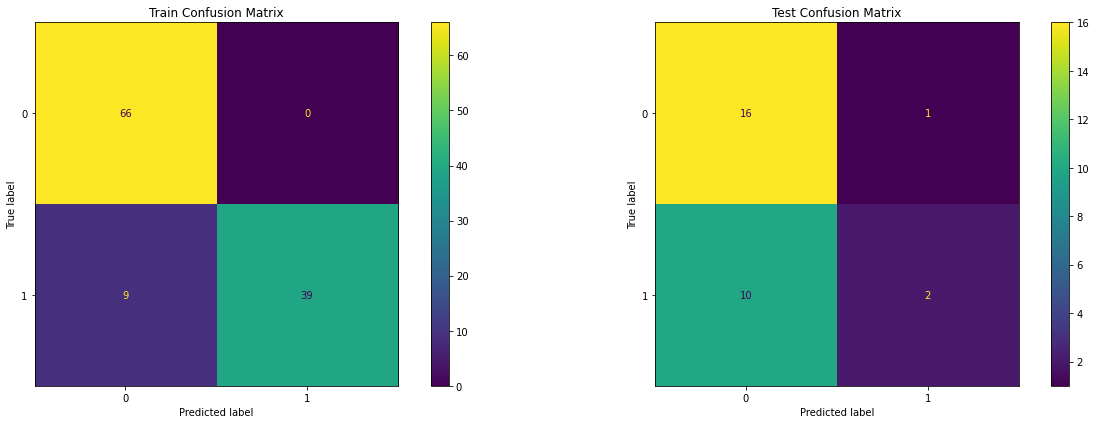

In [116]:
log_model_lem = LogisticRegression()

run_model(log_model_lem, X_lem, y_lem)

## Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        48

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

              precision    recall  f1-score   support

           0       0.70      0.94      0.80        17
           1       0.83      0.42      0.56        12

    accuracy                           0.72        29
   macro avg       0.76      0.68      0.68        29
weighted avg       0.75      0.72      0.70        29



DecisionTreeClassifier()

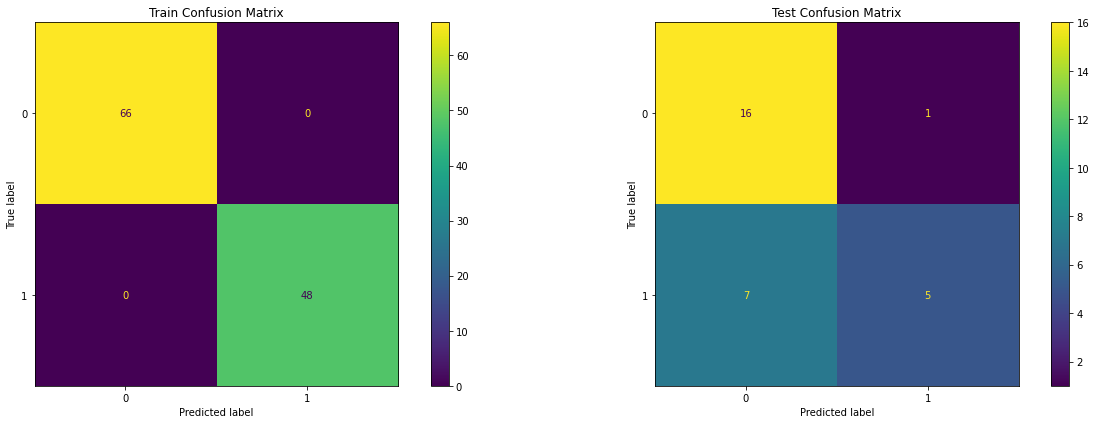

In [117]:
Dtree_lem = DecisionTreeClassifier()

run_model(Dtree_lem, X_lem, y_lem)

## XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        48

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.62      0.42      0.50        12

    accuracy                           0.66        29
   macro avg       0.65      0.62      0.62        29
weighted avg       0.65      0.66      0.64        29



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

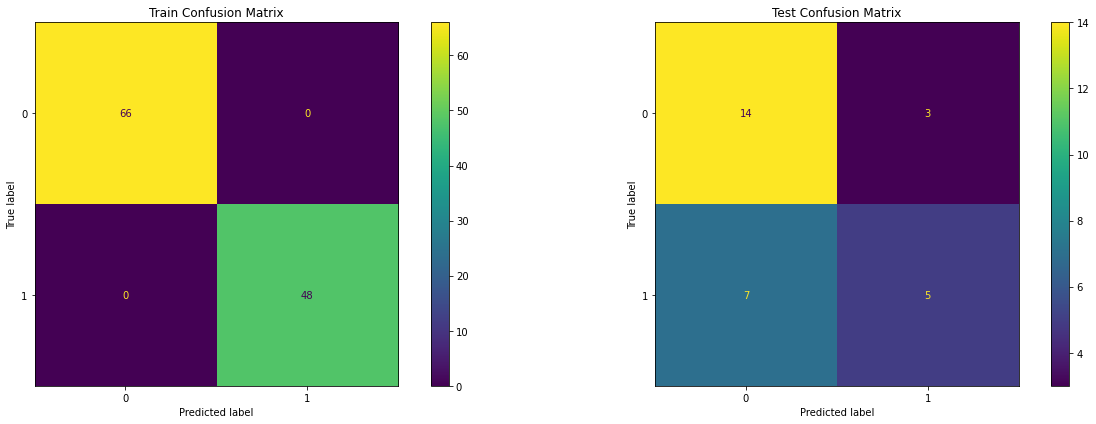

In [118]:
XG_lem = XGBClassifier()

run_model(XG_lem, X_lem, y_lem)

# Hyperparameter Tuning Using GridSearch

I decided to conduct hyperparameter tuning using GridSearch of the top two performing models among the initial models created, K-Nearest Neighbors and Decision Tree:

## K-Nearest Neighbors

In [119]:
param_grid = {
   'leaf_size': [40],
    'n_neighbors': [6],
   'weights': ['uniform'],
  # 'subsample': [0.2,],
   # 'n_estimators': [90, 100, 120],
   #'max_samples': [0.1, 0.2, 0.3]
    #'criterion': ['entropy']
}

In [120]:
grid_clf1 = GridSearchCV(KNN_model, param_grid)

In [121]:
grid_clf1.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsClassifier(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'leaf_size': [40], 'n_neighbors': [6], 'weights': ['uniform']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

              precision    recall  f1-score   support

           0       0.70      0.92      0.80        66
           1       0.81      0.46      0.59        48

    accuracy                           0.73       114
   macro avg       0.76      0.69      0.69       114
weighted avg       0.75      0.73      0.71       114

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        17
           1       0.86      0.50      0.63        12

    accuracy                           0.76        29
   macro avg       0.79      0.72      0.73        29
weighted avg       0.78      0.76      0.74        29



GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [40], 'n_neighbors': [6],
                         'weights': ['uniform']})

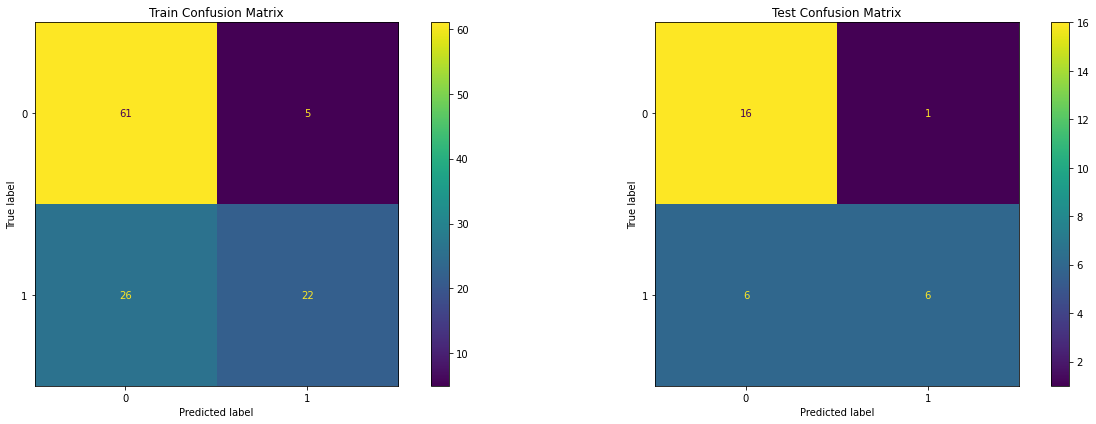

In [122]:
run_model(grid_clf1, X_lem, y_lem)

## Decision Tree

In [123]:
param_grid2 = {
    #'criterion': ['gini'],
    'max_depth': [4],
   'max_features': [6],
   'max_leaf_nodes': [4],
   'random_state': [20],
   #'max_samples': [0.1, 0.2, 0.3]
    'criterion': ['gini']
}

In [124]:
grid_clf2 = GridSearchCV(Dtree_lem, param_grid2)

In [125]:
grid_clf2.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': 'deprecated',
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'max_depth': [4],
  'max_features': [6],
  'max_leaf_nodes': [4],
  'random_state': [20],
  'criterion': ['gini']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

              precision    recall  f1-score   support

           0       0.59      0.98      0.74        66
           1       0.75      0.06      0.12        48

    accuracy                           0.60       114
   macro avg       0.67      0.52      0.43       114
weighted avg       0.66      0.60      0.48       114

              precision    recall  f1-score   support

           0       0.57      0.94      0.71        17
           1       0.00      0.00      0.00        12

    accuracy                           0.55        29
   macro avg       0.29      0.47      0.36        29
weighted avg       0.33      0.55      0.42        29



GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [4],
                         'max_features': [6], 'max_leaf_nodes': [4],
                         'random_state': [20]})

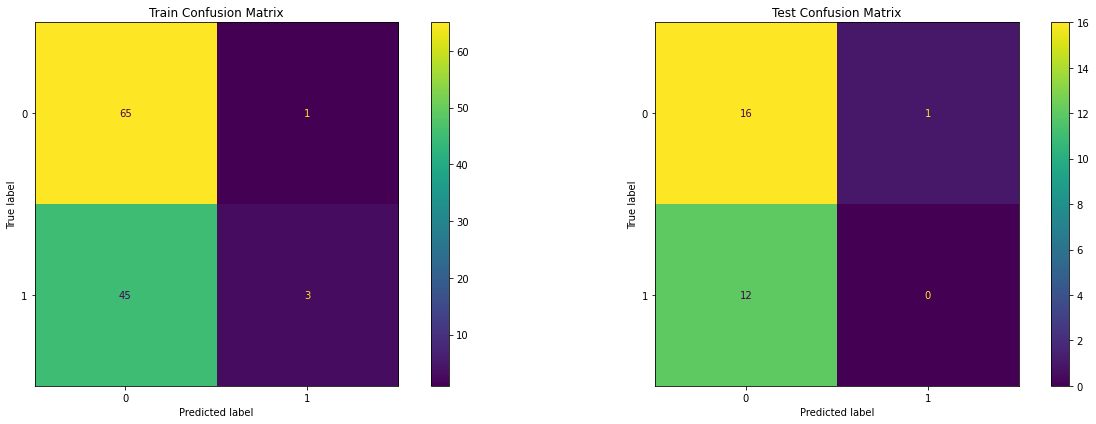

In [126]:
run_model(grid_clf2, X_lem, y_lem)

# Final Model

Based on the results from performing a GridSearch on the selected models, K-Nearest Neighbors produced the outcome when predicting high job approval ratings based on the speech transcripts. Its training accuracy is 73%, while its testing accuracy is 76%, which indicates that the model is appropriately fitted to the data. 

              precision    recall  f1-score   support

           0       0.70      0.92      0.80        66
           1       0.81      0.46      0.59        48

    accuracy                           0.73       114
   macro avg       0.76      0.69      0.69       114
weighted avg       0.75      0.73      0.71       114

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        17
           1       0.86      0.50      0.63        12

    accuracy                           0.76        29
   macro avg       0.79      0.72      0.73        29
weighted avg       0.78      0.76      0.74        29



KNeighborsClassifier(leaf_size=40, n_neighbors=6)

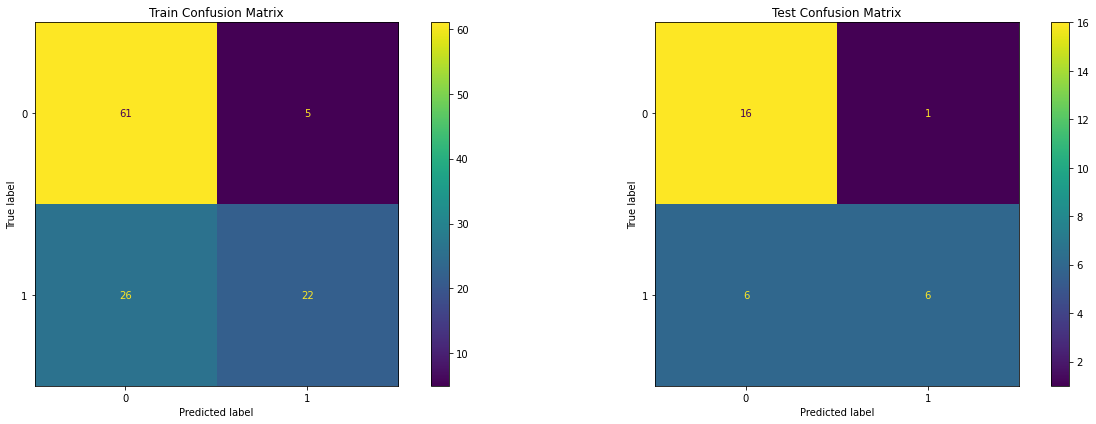

In [129]:
KNNFinal_model = KNeighborsClassifier(
   leaf_size = 40,
    n_neighbors = 6,
   weights = 'uniform')

run_model(KNNFinal_model, X_lem, y_lem)

## Relevant Terms

In this section, I wanted to see if implementing a minimum benchmark of relevant terms in the TF-IDF word vectorized set would affect my final model. I set the minimum to 0.1:

In [130]:
X_train_lem2, X_test_lem2, y_train_lem2, y_test_lem2 = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)

tfidf2 = TfidfVectorizer(min_df=0.1, stop_words=sw_set)

tfidf_data_train_lem2 = tfidf2.fit_transform(X_train_lem2)
tfidf_data_test_lem2 = tfidf2.transform(X_test_lem2)

tfidf_data_train_lem2

<114x2141 sparse matrix of type '<class 'numpy.float64'>'
	with 68833 stored elements in Compressed Sparse Row format>

In [131]:
non_zero_cols2 = tfidf_data_train_lem2.nnz / float(tfidf_data_train_lem2.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols2))

percent_sparse2 = 1 - (non_zero_cols2 / float(tfidf_data_train_lem2.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse2))

Average Number of Non-Zero Elements in Vectorized Articles: 603.7982456140351
Percentage of columns containing ZERO: 0.7179830707080639


In [132]:
KNN_model2 = KNeighborsClassifier()

In [133]:
KNN_model2.fit(tfidf_data_train_lem2, y_train_lem2)

knn_train_preds_lem2 = KNN_model2.predict(tfidf_data_train_lem2)
knn_test_preds_lem2 = KNN_model2.predict(tfidf_data_test_lem2)

In [134]:
print(classification_report(y_train_lem2, knn_train_preds_lem2))
print(classification_report(y_test_lem2, knn_test_preds_lem2))

              precision    recall  f1-score   support

           0       0.73      0.87      0.79        67
           1       0.74      0.55      0.63        47

    accuracy                           0.74       114
   macro avg       0.74      0.71      0.71       114
weighted avg       0.74      0.74      0.73       114

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.80      0.62      0.70        13

    accuracy                           0.76        29
   macro avg       0.77      0.75      0.75        29
weighted avg       0.77      0.76      0.75        29



When I tried to increase the amount of relevant terms in the vectorized word set, my prediction level stayed the same at 76% accuracy. However, the training set accuracy increased by 1%, from 73 to 74 percent.

# Conclusion

* KNN - best model to predict high approval ratings using speech transcripts.
* Most frequent words throughout speeches: People, American, America, Year; terms used to bring people together.
* Words that are more frequent in high than low job approval ratings in top 25: Must, Child. Life.
* Low job approval ratings: Country, Job, Us. 
* Emphasizing children and communicating urgency - leads to high job approval ratings.
* Terms associated with low job approval ratings - used to attempt to bring people together and emphasize the economy; not enough to gain favorable rating.


# Next Steps

* Explore previous presidents and their speech transcripts.
* Analyze Trump’s speeches towards end of his presidency.
* Has the pandemic affected what words are said by Trump/Biden?
* Look at bigrams and tri-grams to see if there are specific phrases presidents use.
* Look at other speeches given to see if there are similarities and/or differences.
* Analyze further how party affiliation impacts job approval ratings; similarities/differences?
* Relationship between speeches and the economy; frequency of words associated with high/low unemployment rates.